## Aprendizaje Automático II - Tarea 3 - Miguel Angel Ruiz Ortiz

Crear un modelo de codificador (encoder) de Transformer para dada una serie de $K$ entradas (horas) de valores de criptomonedas predecir los precios de las siguientes $k$ horas (ver  descripción en la tarea 2).

1. El transformer (encoder) debe constar de al menos 3 etapas. La salida debe ser directamente la predicción. 

2. Probar normalización: logarítmica y banqueo (restar min y dividir entre  (max-min) a cada cripto en la serie). 

3. Usar el prositional encoder propuesto en el Transformer original.

4. Comparar con el baseline de suponer que el precio de la criptomoneda no cambia durante el periodo de predicción, y con el Seq2Seq con atención de la tarea 2. 

## Librerías

In [48]:

import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import math
from typing import Callable
from abc import ABC, abstractmethod
import seaborn as sns

In [2]:
devices = tf.config.list_physical_devices()
print("Devices: ", devices)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


## Funciones útiles

En esta sección definimos funciones útiles para el notebook para entrenar un modelo de la forma ``CustomModel`` (definido como clase abstracta) y plotear la función de costo y métrica durante su entrenamiento.

In [3]:
# Abstract class for typing util functions
class CustomModel(ABC):
    def __init__(self):
        self.model: keras.Model = None

    @abstractmethod
    def fit(
        self,
        X_train: np.ndarray,
        decoder_input_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        decoder_input_val: np.ndarray,
        y_val: np.ndarray,
        **kwargs
    ):
        pass

    @abstractmethod
    def predict(self, X_test: np.ndarray):
        pass

    @abstractmethod
    def compile(self, optimizer: keras.optimizers.Optimizer, loss: str, metrics: list[keras.metrics.Metric]):
        pass

In [4]:
def plot_training_metrics(
    model: CustomModel,
    metric: str,
    metric_name: str,
    loss_name: str,
    n_epochs: int,
    figsize: tuple[int, int] = (14, 5),
):
    # function to plot loss function and metric function when training the given CustomModel

    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(
        range(1, n_epochs),
        model.model.history.history["loss"][1:],
        label="Entrenamiento",
    )
    plt.plot(
        range(1, n_epochs),
        model.model.history.history["val_loss"][1:],
        label="Validación",
    )
    plt.title("Función de pérdida")
    plt.xlabel("Época")
    plt.ylabel(loss_name)

    plt.subplot(1, 2, 2)
    plt.plot(model.model.history.history[metric], label="Entrenamiento")
    plt.plot(model.model.history.history[f"val_{metric}"], label="Validación")
    plt.title(metric_name)
    plt.xlabel("Época")
    plt.ylabel(metric)

    plt.legend()
    plt.show()

In [5]:
def train_model_and_plot(
    model: CustomModel,
    epochs: int, 
    adam_optimizer_params: dict,
    X: np.ndarray,
    decoder_input: np.ndarray,
    y: np.ndarray,
    X_val: np.ndarray,
    decoder_input_val: np.ndarray,
    y_val: np.ndarray
):
    # function to train given CustomModel and plot loss function and metric function
    
    model.compile(
        optimizer=keras.optimizers.Adam(**adam_optimizer_params),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError()],
    )

    model.fit(X, decoder_input, y, X_val, decoder_input_val, y_val, batch_size=64, epochs=epochs)

    plot_training_metrics(model=model, metric="mean_absolute_error", metric_name="Error absoluto medio", loss_name="Error cuadrático medio", n_epochs=epochs)

## Datos

### Datos (Yahoo Finance)

Pedimos con la librería ``yfinance`` para descargar el precio (con respecto al dólar) de una criptomoneda dada a través de la API de Yahoo Finance. Las criptomonedas que se consideraron son:
- Bitcoin (BTC), 
- Ethereum (ETH), 
- Binance Coin (BNB), 
- XRP (Ripple), 
- Cardano (ADA), 
- Solana (SOL), 
- Dogecoin (DOGE)

Los precios son cada hora, durante 1 año. Abarcan desde 2023-09-18 03:00:00+00:00 hasta 2024-09-18 02:00:00+00:00 (las mismas fechas que se usaron para los datos de la tarea 2). Además, se utilizó la estrategia de rellenar los valores faltantes hacia adelante ("forward fill"), i.e., con el dato disponible anterior.

Los datos se leen del archivo ``cryptocoins-timeseries.csv``, el cual se genera a través del script ``download_data.py``.

In [6]:
cryptos = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "ADA-USD", "SOL-USD", "DOGE-USD"]

dataset_df = pd.read_csv("cryptocoins-timeseries.csv", parse_dates=[0], index_col=0)

dataset_df.head()

BTC-USD      ETH-USD     BNB-USD   XRP-USD  \
2023-09-18 03:00:00+00:00  26659.097656  1629.741455  217.830093  0.497337   
2023-09-18 04:00:00+00:00  26624.929688  1630.428589  217.081177  0.497421   
2023-09-18 05:00:00+00:00  26668.037109  1631.512207  217.270325  0.495707   
2023-09-18 06:00:00+00:00  26672.318359  1630.511108  217.335846  0.493208   
2023-09-18 07:00:00+00:00  26712.169922  1634.266113  216.986725  0.491757   

                            ADA-USD    SOL-USD  DOGE-USD  
2023-09-18 03:00:00+00:00  0.249284  19.204222  0.061809  
2023-09-18 04:00:00+00:00  0.249350  19.059607  0.061723  
2023-09-18 05:00:00+00:00  0.249015  19.137966  0.061782  
2023-09-18 06:00:00+00:00  0.248663  19.120892  0.061766  
2023-09-18 07:00:00+00:00  0.248552  19.118294  0.061820

### Creación de datasets de entrenamiento, validación y prueba

Un elemento de nuestro dataset para el modelo es una secuencia $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ de tamaño $\tau$ donde $x_j$ es un vector con los precios de las 7 criptomonedas al tiempo $j$. Dada dicha secuencia, el modelo va a predecir los siguientes $m$ datos, es decir, la secuencia $(x_{t+\tau}, ..., x_{t+\tau+m-1})$. Para poder aplicar el forzamiento del maestro ("teacher forcing"), el decoder necesita la secuencia que va a predecir pero trasladada un paso en el tiempo hacia atrás, i.e., $(x_{t+\tau-1}, ..., x_{t+\tau+m-2})$. 

Para que el modelo no tenga "información del futuro", se usarán los primeros ``n_train`` datos de cada serie para formar el conjunto de entrenamiento, los siguientes ``n_val`` para el conjunto de validación, y los últimos ``n_test`` para el conjunto de prueba. Es decir, los tiempo en el dataset de entrenamiento son antes que los tiempos en el dataset de validación, y a su vez estos tiempos son antes de los tiempos en el dataset de prueba.

In [7]:
data = dataset_df.to_numpy()

total_data = len(dataset_df)

n_train = int(total_data * 0.60)
n_val = int(total_data * 0.20)
n_test = total_data - n_train - n_val

print(f"Total de datos: {total_data}")
print(f"- Entrenamiento: {n_train} datos")
print(f"- Validación: {n_val} datos")
print(f"- Prueba: {n_test} datos")

train_data = data[:n_train]
val_data = data[n_train : n_train + n_val]
test_data = data[-n_test:]

Total de datos: 8784
- Entrenamiento: 5270 datos
- Validación: 1756 datos
- Prueba: 1758 datos


In [8]:
T = 100
m = 5
tau = T - m

Para evitar un sobreajuste, no le damos todas las posibles secuencias $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ de tamaño $\tau$ del conjunto de entrenamiento, si no sólo un 85% de ellas de manera aleatoria.

In [9]:
np.random.seed(0)

train_indices = np.random.choice(
    n_train - T, int(0.85 * (n_train - T)), replace=False
)  # time for index i corresponds to time_index[i]

X_train_raw = np.array([train_data[i : i + T] for i in train_indices])
X_train_raw, y_train_raw, decoder_input_train_raw = (
    X_train_raw[:, : T - m, :].copy(),
    X_train_raw[:, -m:, :].copy(),
    X_train_raw[:, -m - 1 : -1, :].copy(),
)

X_val_raw = np.array([val_data[i : i + T] for i in range(n_val - T)])
X_val_raw, y_val_raw, decoder_input_val_raw = (
    X_val_raw[:, : T - m, :].copy(),
    X_val_raw[:, -m:, :].copy(),
    X_val_raw[:, -m - 1 : -1, :].copy(),
)

X_test_raw = np.array([test_data[i : i + T] for i in range(n_test - T)])
X_test_raw, y_test_raw, decoder_input_test_raw = (
    X_test_raw[:, : T - m, :].copy(),
    X_test_raw[:, -m:, :].copy(),
    X_test_raw[:, -m - 1 : -1, :].copy(),
)

In [10]:
time_index = dataset_df.index

def index2timestamp(i: int, dataset_type: str) -> pd.Timestamp:
    # auxiliar function to know the timestamp t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1}), given the index i in the corresponding dataset ("train", "val", "test")
    if dataset_type == "train":
        return time_index[i]
    if dataset_type == "val":
        return time_index[n_train + i]
    if dataset_type == "test":
        return time_index[-n_test + i]

### Preprocesamiento

Vamos a utilizar las siguientes estrategias de preprocesamiento de los datos:
1. Normalización local: a cada secuencia se le calcula su propia media y desviación estándar para normalizar sólo esa secuencia por cada criptomoneda.
2. Banqueo (Min-Max scaling) local: cada secuencia se transforma al intervalo [0, 1] de manera lineal, utilizando el máximo y el mínimo de esa secuencia.
3. Escala logarítmica: se aplica logaritmo a las series de tiempo.

Recordemos que las series de tiempo financieras tienen un comportamiento cambiante a lo largo del tiempo, por ejemplo una volatilidad (varianza) que depende del tiempo tiempo. Por esto conviene utilizar un preprocesamiento *local* de los datos, en la que se aplica el preprocesamiento a cada secuencia de input. En el caso de la normalización local, a cada secuencia se le calcula su propia media y desviación estándar para normalizar sólo esa secuencia por cada criptomoneda.

#### Normalización local

In [11]:
class LocalNormalization:
    def __init__(self, sequences: np.ndarray):
        # compute vector of means and standard deviations, for each sequence
        
        self.means = sequences.mean(axis=1)  # vector mu of means for each sequence, i.e., mu[i] is the vector of means for each feature of sequence i
        self.stds = sequences.std(axis=1)  # vector of standard deviations for each sequence
    
    def transform(self, sequences: np.ndarray) -> np.ndarray:
        sequences_norm = np.zeros(sequences.shape)
        
        for i in range(sequences.shape[0]):
            sequences_norm[i] = (sequences[i] - self.means[i]) / self.stds[i]
            
        return sequences_norm
    
    def inverse_transform(self, sequences_norm: np.ndarray) -> np.ndarray:
        sequences_raw = np.zeros(sequences_norm.shape)

        for i in range(sequences_norm.shape[0]):
            sequences_raw[i] = self.stds[i] * sequences_norm[i] + self.means[i]

        return sequences_raw

In [12]:
norm_train = LocalNormalization(X_train_raw)
X_train_norm = norm_train.transform(X_train_raw)
y_train_norm = norm_train.transform(y_train_raw)
decoder_input_train_norm = norm_train.transform(decoder_input_train_raw)

norm_val = LocalNormalization(X_val_raw)
X_val_norm = norm_val.transform(X_val_raw)
y_val_norm = norm_val.transform(y_val_raw)
decoder_input_val_norm = norm_val.transform(decoder_input_val_raw)

norm_test = LocalNormalization(X_test_raw)
X_test_norm = norm_test.transform(X_test_raw)
y_test_norm = norm_test.transform(y_test_raw)
decoder_input_test_norm = norm_test.transform(decoder_input_test_raw)

#### Banqueo (Min-Max scaling) local

In [13]:
class LocalMinMaxScaling:
    def __init__(self, sequences: np.ndarray):
        # compute vector of minimums and maximums, for each sequence
        
        self.min = sequences.min(axis=1)  # vector of minimums for each sequence, i.e.,  min[i] is the vector of minimums of each feature in sequence i
        self.max = sequences.max(axis=1)  # vector of maximums for each sequence
    
    def transform(self, sequences: np.ndarray) -> np.ndarray:
        sequences_scaled = np.zeros(sequences.shape)
        
        for i in range(sequences.shape[0]):
            sequences_scaled[i] = (sequences[i] - self.min[i]) / (self.max[i] - self.min[i])
            
        return sequences_scaled
    
    def inverse_transform(self, sequences_scaled: np.ndarray) -> np.ndarray:
        sequences_raw = np.zeros(sequences_scaled.shape)

        for i in range(sequences_scaled.shape[0]):
            sequences_raw[i] = (self.max[i] - self.min[i]) * sequences_scaled[i] + self.min[i]

        return sequences_raw

In [14]:
minmax_scaler_train = LocalMinMaxScaling(X_train_raw)
X_train_minmax = minmax_scaler_train.transform(X_train_raw)
y_train_minmax = minmax_scaler_train.transform(y_train_raw)
decoder_input_train_minmax = minmax_scaler_train.transform(decoder_input_train_raw)

minmax_scaler_val = LocalMinMaxScaling(X_val_raw)
X_val_minmax = minmax_scaler_val.transform(X_val_raw)
y_val_minmax = minmax_scaler_val.transform(y_val_raw)
decoder_input_val_minmax = minmax_scaler_val.transform(decoder_input_val_raw)

minmax_scaler_test = LocalMinMaxScaling(X_test_raw)
X_test_minmax = minmax_scaler_test.transform(X_test_raw)
y_test_minmax = minmax_scaler_test.transform(y_test_raw)
decoder_input_test_minmax = minmax_scaler_test.transform(decoder_input_test_raw)

#### Escala logarítmica

In [15]:
X_train_log = np.log(X_train_raw)
y_train_log = np.log(y_train_raw)
decoder_input_train_log = np.log(decoder_input_train_raw)

X_val_log = np.log(X_val_raw)
y_val_log = np.log(y_val_raw)
decoder_input_val_log = np.log(decoder_input_val_raw)

X_test_log = np.log(X_test_raw)
y_test_log = np.log(y_test_raw)
decoder_input_test_log = np.log(decoder_input_test_raw)

## Seq2Seq + Atención

En esta sección sólo volvemos a utilizar el código de la tarea 2 para obtener las predicciones hechas del modelo Seq2Seq con atención. Recordemos que en dicha tarea sólo aplicamos el Seq2Seq con atención a los datos con normalización local.

In [19]:
class MultiplicativeAttention(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()

        # dense layer to compute multiplicative style scores
        self.score_dense = keras.layers.Dense(units, use_bias=False)

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]) -> tuple[tf.Tensor, tf.Tensor]:
        query, key = (
            inputs  # query are the hidden states of decoder, and key are the hidden states of encoder
        )

        # Compute attention scores QxWxK^T
        scores = tf.matmul(query, self.score_dense(key), transpose_b=True)

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Compute context vector as weighted average of encoder's hidden states
        context = tf.matmul(attention_weights, key)

        return context, attention_weights


class Seq2SeqAttention:
    def __init__(self, latent_dim: int, dim_vectors: int, n_steps: int):
        self.dim_vectors = dim_vectors
        self.n_steps = n_steps

        # encoder
        encoder_inputs = keras.layers.Input(shape=(None, dim_vectors))
        encoder_o, encoder_h, encoder_c = keras.layers.LSTM(
            units=latent_dim, return_sequences=True, return_state=True
        )(encoder_inputs)
        encoder_states = [encoder_h, encoder_c]

        # decoder
        decoder_inputs = keras.layers.Input(shape=(None, dim_vectors))
        decoder_lstm = keras.layers.LSTM(
            units=latent_dim, return_sequences=True, return_state=True
        )
        decoder_o, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

        attention_layer = MultiplicativeAttention(latent_dim)
        context, attention_weights = attention_layer([decoder_o, encoder_o])

        # Concatenate attention output and decoder LSTM output
        decoder_concat_input = keras.layers.Concatenate(axis=-1)([decoder_o, context])

        # last dense layer
        decoder_dense = keras.layers.Dense(dim_vectors)
        decoder_outputs = decoder_dense(decoder_concat_input)

        # Define the full model that will be trained with teacher forcing
        self.model = keras.models.Model(
            [encoder_inputs, decoder_inputs], decoder_outputs
        )

        # encoder for inference
        self.encoder_model = keras.models.Model(
            encoder_inputs, [encoder_o] + encoder_states
        )

        # adapted decoder for inference, using one output decoder as the next input of it
        decoder_state_input_h = keras.layers.Input(shape=(latent_dim,))
        decoder_state_input_c = keras.layers.Input(shape=(latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        encoder_o_inf = keras.layers.Input(shape=(None, latent_dim))

        decoder_inf_o, state_h, state_c = decoder_lstm(
            decoder_inputs, initial_state=decoder_states_inputs
        )
        context_inf, attention_weights_inf = attention_layer(
            [decoder_inf_o, encoder_o_inf]
        )
        decoder_inf_concat = keras.layers.Concatenate(axis=-1)(
            [decoder_inf_o, context_inf]
        )
        decoder_inf_outputs = decoder_dense(decoder_inf_concat)

        self.decoder_model = keras.models.Model(
            [decoder_inputs, encoder_o_inf] + decoder_states_inputs,
            [decoder_inf_outputs, state_h, state_c],
        )

    def compile(
        self,
        optimizer: keras.optimizers.Optimizer,
        loss: str,
        metrics: list[keras.metrics.Metric],
    ):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(
        self,
        X_train: np.ndarray,
        decoder_input_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        decoder_input_val: np.ndarray,
        y_val: np.ndarray,
        **kwargs
    ):

        self.model.fit(
            [X_train, decoder_input_train],
            y_train,
            validation_data=([X_val, decoder_input_val], y_val),
            **kwargs
        )

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        encoder_o, state_h, state_c = self.encoder_model.predict(X_test)
        last_values = X_test[:, -1:, :]
        pred_test = np.zeros(shape=(X_test.shape[0], self.n_steps, self.dim_vectors))

        for i in range(self.n_steps):
            last_values, state_h, state_c = self.decoder_model.predict(
                [last_values, encoder_o, state_h, state_c]
            )
            pred_test[:, i, :] = last_values[:, 0, :]

        return pred_test

Epoch 1/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 1.5305 - mean_absolute_error: 0.9237 - val_loss: 0.3950 - val_mean_absolute_error: 0.4341
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.3368 - mean_absolute_error: 0.3852 - val_loss: 0.2347 - val_mean_absolute_error: 0.3211
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.2127 - mean_absolute_error: 0.2948 - val_loss: 0.1995 - val_mean_absolute_error: 0.2879
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.2087 - mean_absolute_error: 0.2851 - val_loss: 0.1854 - val_mean_absolute_error: 0.2720
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.2067 - mean_absolute_error: 0.2925 - val_loss: 0.1797 - val_mean_absolute_error: 0.2648
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1787 - mean_absolute_error: 0.2644 - val_loss: 0.1777 - val_mean_absolute_error: 0.2657
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.1719 - mean_absolute_error: 0.2585 - val_loss

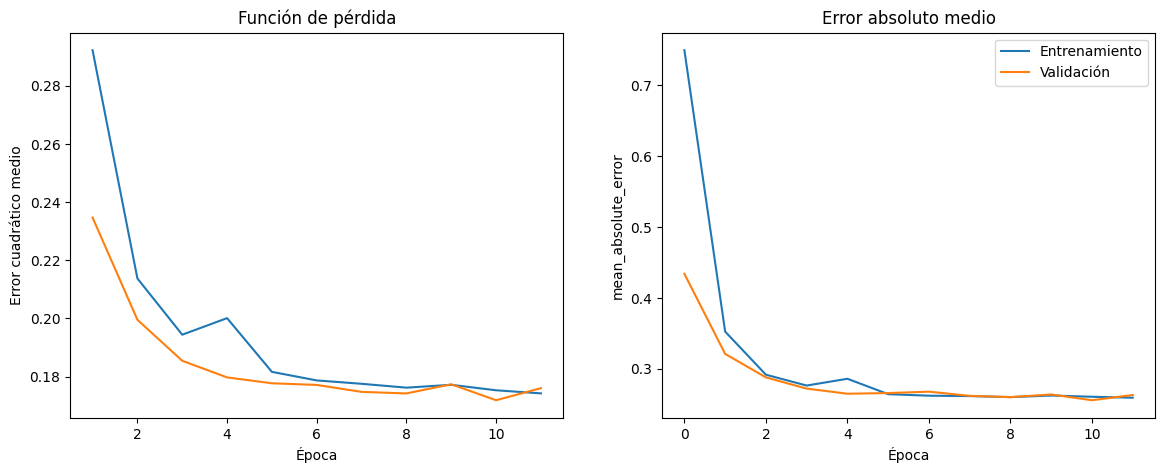

In [20]:
latent_dim = 512
dim_vectors = 7

seq2seq_attention_model = Seq2SeqAttention(latent_dim, dim_vectors, n_steps=m)

epochs = 12

train_model_and_plot(
    model=seq2seq_attention_model,
    epochs=epochs,
    adam_optimizer_params={}, # default Adam optimizer as in last homework
    X=X_train_norm,
    decoder_input=decoder_input_train_norm,
    y=y_train_norm,
    X_val=X_val_norm,
    decoder_input_val=decoder_input_val_norm,
    y_val=y_val_norm,
)

In [21]:
n_features = 7

pred_seq2seq = seq2seq_attention_model.predict(X_test_norm)  # predictions
pred_seq2seq_flat = pred_seq2seq.reshape(-1, n_features)
y_test_norm_flat = y_test_norm.reshape(-1, n_features)  # ground truth

mae_seq2seq = mean_absolute_error(y_test_norm_flat, pred_seq2seq_flat, multioutput="raw_values")

print("\nErrores absolutos medios en la escala normalizada:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_seq2seq[i])

pred_seq2seq_raw = norm_test.inverse_transform(pred_seq2seq)  # predicted prices
pred_raw_flat = pred_seq2seq_raw.reshape(-1, n_features)
y_test_raw_flat = y_test_raw.reshape(-1, n_features)

mae_seq2seq_raw = mean_absolute_error(
    y_test_raw_flat, pred_raw_flat, multioutput="raw_values"
)

print("\nErrores absolutos medios en la escala de los precios:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_seq2seq_raw[i])

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.45542587982619204
ETH-USD : 0.5711277299565253
BNB-USD : 0.47616526374096674
XRP-USD : 0.5657727913704863
ADA-USD : 0.4004392275420711
SOL-USD : 0.4302416302618031
DOGE-USD : 0.3993080704500496

Errores absolutos medios en la escala de los precios:
BTC-USD : 528.2115984282818
ETH-USD : 34.604396889899014
BNB-USD : 4.89476135101261
XRP-USD : 0.00780442799510816
ADA-USD : 0.0034819680514253664
SOL-USD : 1.7867286608086776
DOGE-USD : 0.0011467200470803667


## Transformer Encoder

La arquitectura del encoder del Transformer se muestra en el siguiente diagrama:

<div style="text-align: center">
<img src="transformer-encoder.png" height="500px" />
</div>

### Positional embedding

Implementamos la capa de *positional embedding* en la que se suma a los embeddings de input un vector que contiene la información de la posicición de un vector en la secuencia. El vector $PE_{pos}$ que se le suma al vector en la posición *pos* de una secuencia está dado por
$$
PE_{pos}[2i] = \sin(pos/10000^{2i/d}), \quad \quad PE_{pos}[2i+1] = \cos(pos/10000^{2i/d})
$$
donde $d$ es la dimensión de los embeddings de input, y $2i, 2i+1$ representan una dimensión del *positional encoding* $PE_{pos}$.

In [22]:
def positional_embedding(pos: int, k: int, d_model: int) -> float:
    i = k // 2  # k = 2*i + (k%2)

    if k % 2 == 0:
        return math.sin(pos / (10000 ** (2 * i / d_model)))
    else:
        return math.cos(pos / (10000 ** (2 * i / d_model)))


class ClassicPositionalEmbedding(keras.Layer):
    def __init__(self, max_length: int, d_model: int):
        super().__init__()
        
        self.max_length = max_length

        # creating positional encodings
        self.pos_encoding = tf.constant(
            [
                [positional_embedding(pos, k, d_model) for k in range(d_model)]
                for pos in range(max_length)
            ]
        )

    def call(self, inputs):
        # add positional encoding to input
        # we assume inputs have shape (batch_size, N, d_model), where N <= max_length
        # if inputs_length is None, then we assume inputs_length equals max_length
        N = inputs.shape[1]
            
        return inputs + self.pos_encoding[:N, :]

### Feed-forward sublayer and encoder layer

En el diagrama se observa que después del *positional embedding* se itera $N$ veces (en esta tarea $N=3$) una capa implementada en la clase ``EncoderLayer``.  Esta capa se compone de un mecanismo de atención multi-cabeza y una red *feed-forward* con dos capas densas. También consta de conexiones residuales alrededor de ambos procesos seguido de una normalización de capa (``LayerNormalization``). Se implementó en la clase ``FeedForward`` la subcapa compuesta de la red *feed-forward* con la conexión residual y la normalización de capa.

In [23]:
class FeedForward(tf.keras.Layer):
    def __init__(self, d_model: int, dff: int):
        super().__init__()

        # two linear transformations with a ReLU activation function between
        self.feedforward_net = keras.models.Sequential(
            [
                keras.layers.Dense(dff, activation="relu"),
                keras.layers.Dense(d_model),
            ]
        )

        # Residual connection
        self.add = tf.keras.layers.Add()

        # Layer Normalization
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs):
        x = self.feedforward_net(inputs)
        x = self.add([inputs, x])
        x = self.layer_norm(x)
        return x


class EncoderLayer(keras.Layer):
    def __init__(self, num_heads: int, dim_qkv: int, d_model: int, dff: int):
        super().__init__()

        # Multi-Head attention layer
        self.multi_head_attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=dim_qkv, use_bias=False
        )

        # Residual connection
        self.add_layer = keras.layers.Add()

        # Layer Normalization
        self.layer_norm = keras.layers.LayerNormalization()

        # Feed-Forward Network
        self.ff_sublayer = FeedForward(d_model=d_model, dff=dff)

    def call(self, inputs):
        x = self.multi_head_attention(query=inputs, value=inputs)
        x = self.add_layer([inputs, x])
        x = self.layer_norm(x)
        x = self.ff_sublayer(x)

        return x

### Transformer Encoder

Finalmente pegamos todas las piezas del encoder del Transformer, tomando en cuenta que ``EncoderLayer`` se debe iterar un número ``n_layers`` dado de veces. El modelo recibe el número ``num_head`` de cabezas a usar en el mecanismo de atención, la dimensión del input embedding ``d_model``, la dimensión ``dim_qkv`` de las proyecciones que entran a las cabezas de atención, la longitud ``sequence_length`` de las secuencias de input, y el número de neuronas ``dff`` que se usan en distintas capas densas a lo largo del pipeline.

In [24]:
class TransformerEncoder(keras.Model):
    def __init__(
        self,
        num_heads: int,
        n_layers: int,
        sequence_length: int,
        d_model: int,
        dim_qkv: int,
        dff: int,
    ):
        super().__init__()
        
        self.num_head = num_heads
        self.n_layers = n_layers
        self.d_model = d_model
        self.dim_qkv = dim_qkv

        self.positional_encoding = ClassicPositionalEmbedding(
            max_length=sequence_length, d_model=d_model
        )
        self.encoder_layers = [
            EncoderLayer(num_heads=num_heads, dim_qkv=dim_qkv, d_model=d_model, dff=dff) for _ in range(n_layers)
        ]

    def call(self, inputs):
        x = self.positional_encoding(inputs)

        for i in range(self.n_layers):
            x = self.encoder_layers[i](x)
            
        return x
        

### Custom Decoder

El output del encoder es una secuencia de longitud ``sequence_length`` de vectores de dimensión ``d_model``. Por lo que nos falta un decoder que transforme esa secuencia en la secuencia de predicción de longitud ``pred_steps`` con vectores de dimensión 7 (el número de criptomonedas). El decoder que aquí usamos trata de imitar al decoder del Transformer pero quitando el mecanismo de atención enmascarada (*Masked Multi-Head Attention*). Recordemos que el decoder tiene como input la secuencia que va a predecir pero trasladada un tiempo hacia atrás. El flujo del decoder es el siguiente: 
1. A la secuencia input del decoder se le suma el *Positional Encoding*.
2. Se realiza un mecanismo de atención multi-cabeza en la que la *query* es el estado del decoder, mientras que la *key* y el *value* es el output del encoder. 
3. Conexión residual entre el input y el output del mecanismo de atención, seguido de una normalización de capa (``LayerNormalization``).
4. Se aplica una red *feed-forward* con dos capas densas. 
5. Conexión residual entre el input y el output de la red *feed-forward*, seguido de una normalización de capa (``LayerNormalization``).

Los pasos 2, 3 y 4 se pueden iterar un número dado de veces como en el encoder.

In [25]:
class CustomDecoder(keras.Layer):
    def __init__(
        self, num_heads: int, dim_qkv: int, d_model: int, dff: int, pred_steps: int
    ):
        super().__init__()

        # positional encoding for decoder input
        self.positional_embedding = ClassicPositionalEmbedding(
            max_length=pred_steps, d_model=d_model
        )

        # Multi-Head attention layer
        self.multi_head_attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=dim_qkv, use_bias=False
        )

        # Residual connection
        self.add_layer = keras.layers.Add()

        # Layer Normalization
        self.layer_norm = keras.layers.LayerNormalization()

        # Feed-Forward
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(dff, activation="relu"),
                keras.layers.Dense(d_model),
            ]
        )

    def call(self, query, value):
        # query is the decoder input, while value is the output of the encoder

        query = self.positional_embedding(query)
        x = self.multi_head_attention(query=query, value=value)
        x = self.add_layer([query, x])
        x = self.layer_norm(x)
        x = self.ffn(x)  # shape: (batch_size, decoder_input_length, d_model)

        return x

### Time series prediction using Transformer Encoder + Custom Decoder

Finalmente definimos el modelo completo utilizando el encoder del Transformer y nuestro decoder. 

In [26]:
class TimeSeriesModel:
    def __init__(
        self,
        num_heads: int,
        n_layers: int,
        sequence_length: int,
        d_model: int,
        dim_qkv: int,
        dff: int,
        pred_steps: int,
    ):
        self.pred_steps = pred_steps

        # transformer encoder
        self.transformer_encoder = TransformerEncoder(
            num_heads=num_heads,
            n_layers=n_layers,
            sequence_length=sequence_length,
            d_model=d_model,
            dim_qkv=dim_qkv,
            dff=dff,
        )

        # decoder
        self.custom_decoder = CustomDecoder(
            num_heads=num_heads,
            dim_qkv=dim_qkv,
            d_model=d_model,
            dff=dff,
            pred_steps=pred_steps,
        )

        # pipeline definition
        encoder_inputs = keras.layers.Input(shape=(None, d_model))
        decoder_inputs = keras.layers.Input(shape=(None, d_model))

        encoder_output = self.transformer_encoder(encoder_inputs)
        output_seq = self.custom_decoder(decoder_inputs, encoder_output)

        self.model = keras.Model([encoder_inputs, decoder_inputs], output_seq)

    def compile(
        self,
        optimizer: keras.optimizers.Optimizer,
        loss: str,
        metrics: list[keras.metrics.Metric],
    ):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(
        self,
        X_train: np.ndarray,
        decoder_input_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        decoder_input_val: np.ndarray,
        y_val: np.ndarray,
        **kwargs
    ):
        self.model.fit(
            [X_train, decoder_input_train],
            y_train,
            validation_data=([X_val, decoder_input_val], y_val),
            **kwargs
        )

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        encoder_output = self.transformer_encoder.predict(X_test)
        decoder_input = X_test[:, -1:, :]  # decoder input first is the last step of the input

        pred_test = np.zeros(shape=(X_test.shape[0], self.pred_steps, X_test.shape[-1]))

        for i in range(self.pred_steps):
            output_seq = self.custom_decoder(decoder_input, encoder_output)  # shape = (batch_size, decoder_input_length, d_model)
            pred_test[:, i, :] = output_seq[:, -1, :]  # select only the predicted new step
            decoder_input = tf.concat([decoder_input, output_seq[:, -1:, :]], axis=1)

        return pred_test

## Entrenamiento

Parámetros del modelo

In [27]:
num_heads = 3
d_model = 7 # number of cryptos
dim_qkv = 4 # dimension of query, key and values for MultiHeadAttention layer
dff = 512 # number of neurons of first layer in feed-forward networks
n_layers = 3

#### Modelo para datos con normalización local

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - loss: 1.7490 - mean_absolute_error: 0.9815 - val_loss: 0.6839 - val_mean_absolute_error: 0.5923
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.6184 - mean_absolute_error: 0.5656 - val_loss: 0.5589 - val_mean_absolute_error: 0.5420
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.5016 - mean_absolute_error: 0.5035 - val_loss: 0.5228 - val_mean_absolute_error: 0.5220
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.4429 - mean_absolute_error: 0.4668 - val_loss: 0.5036 - val_mean_absolute_error: 0.4965
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.4075 - mean_absolute_error: 0.4358 - val_loss: 0.4775 - val_mean_absolute_error: 0.4764
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.3645 - mean_absolute_error: 0.4198 - val_loss: 0.5259 - val_mean_absolute_error: 0.5107
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.3690 - mean_absolute_error: 0.4227 - val_lo

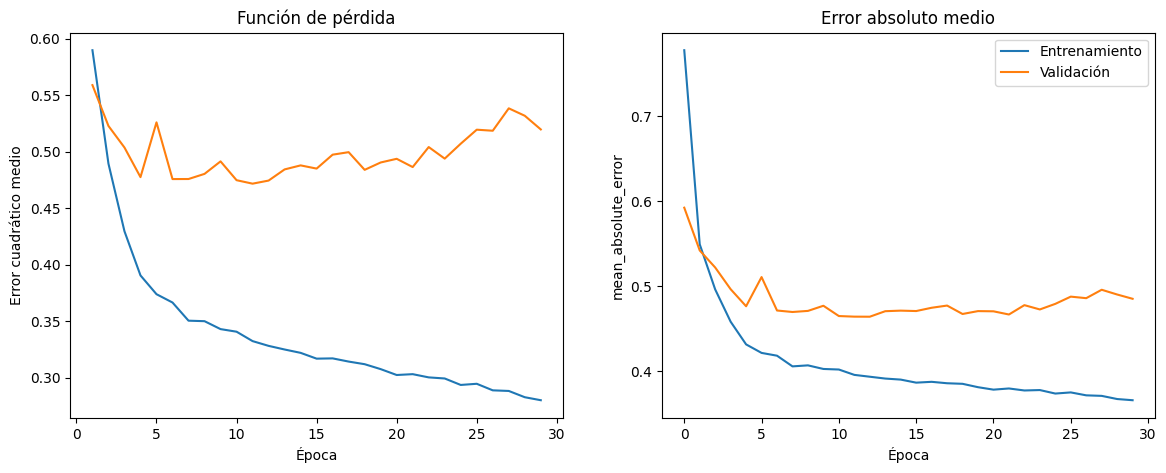

In [28]:
model_norm = TimeSeriesModel(
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 30

train_model_and_plot(
    model=model_norm,
    epochs=epochs,
    adam_optimizer_params=dict(learning_rate=0.002, beta_1=0.85, beta_2=0.999),
    X=X_train_norm,
    decoder_input=decoder_input_train_norm,
    y=y_train_norm,
    X_val=X_val_norm,
    decoder_input_val=decoder_input_val_norm,
    y_val=y_val_norm,
)

#### Modelo para datos con banqueo local

Epoch 1/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - loss: 0.1579 - mean_absolute_error: 0.3171 - val_loss: 0.1197 - val_mean_absolute_error: 0.2850
Epoch 2/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0787 - mean_absolute_error: 0.2214 - val_loss: 0.0397 - val_mean_absolute_error: 0.1458
Epoch 3/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0315 - mean_absolute_error: 0.1272 - val_loss: 0.0332 - val_mean_absolute_error: 0.1308
Epoch 4/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0264 - mean_absolute_error: 0.1157 - val_loss: 0.0308 - val_mean_absolute_error: 0.1249
Epoch 5/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0235 - mean_absolute_error: 0.1078 - val_loss: 0.0304 - val_mean_absolute_error: 0.1237
Epoch 6/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0245 - mean_absolute_error: 0.1087 - val_loss: 0.0319 - val_mean_absolute_error: 0.1272
Epoch 7/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0238 - mean_absolute_error: 0.1069 - val_lo

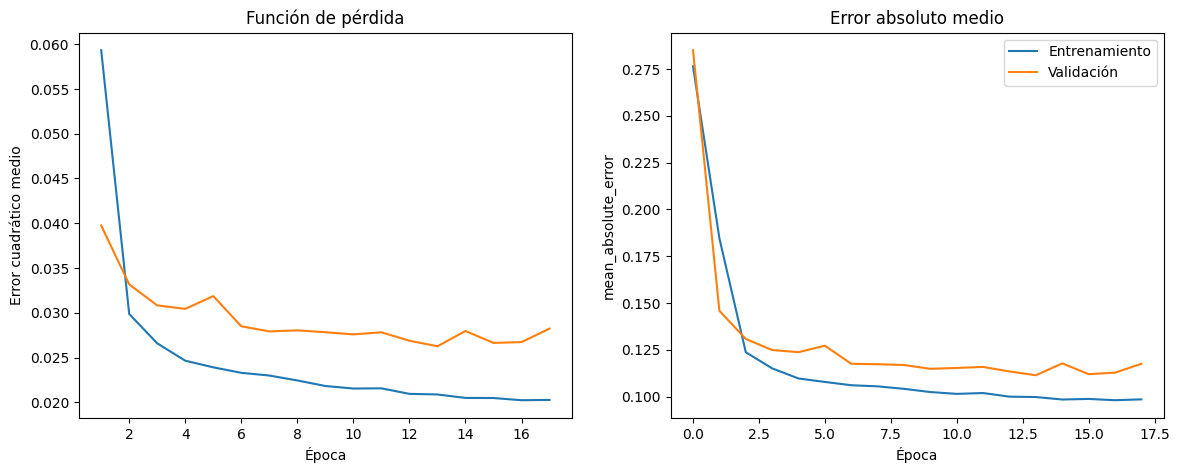

In [29]:
model_minmax = TimeSeriesModel(
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 18

train_model_and_plot(
    model=model_minmax,
    epochs=epochs,
    adam_optimizer_params=dict(learning_rate=0.002, beta_1=0.85, beta_2=0.999),
    X=X_train_minmax,
    decoder_input=decoder_input_train_minmax,
    y=y_train_minmax,
    X_val=X_val_minmax,
    decoder_input_val=decoder_input_val_minmax,
    y_val=y_val_minmax,
)

#### Modelo para datos en escala logarítmica

Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 191ms/step - loss: 16.2435 - mean_absolute_error: 2.6452 - val_loss: 0.1685 - val_mean_absolute_error: 0.3376
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.1068 - mean_absolute_error: 0.2366 - val_loss: 0.0543 - val_mean_absolute_error: 0.1884
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0241 - mean_absolute_error: 0.1210 - val_loss: 0.0428 - val_mean_absolute_error: 0.1598
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0109 - mean_absolute_error: 0.0833 - val_loss: 0.0280 - val_mean_absolute_error: 0.1301
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0074 - mean_absolute_error: 0.0678 - val_loss: 0.0301 - val_mean_absolute_error: 0.1286
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0069 - mean_absolute_error: 0.0647 - val_loss: 0.0306 - val_mean_absolute_error: 0.1304
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0063 - mean_absolute_error: 0.0610 - val_

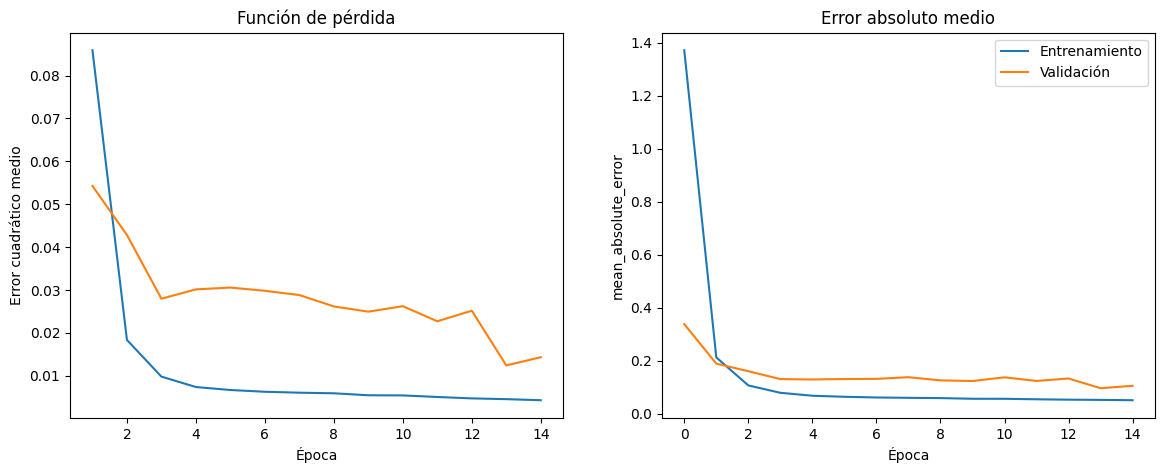

In [30]:
model_log = TimeSeriesModel(
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 15

train_model_and_plot(
    model=model_log,
    epochs=epochs,
    adam_optimizer_params=dict(learning_rate=0.002, beta_1=0.85, beta_2=0.999),
    X=X_train_log,
    decoder_input=decoder_input_train_log,
    y=y_train_log,
    X_val=X_val_log,
    decoder_input_val=decoder_input_val_log,
    y_val=y_val_log,
)

## Inferencia

Por cada tipo de preprocesamiento, vamos a predecir con el conjunto de prueba y obtener el error absoluto medio obtenido en cada serie de tiempo en la escala de los datos preprocesados y en la escala de los precios. La predicciones se verán gráficamente escogiendo aleatoriamente 4 tiempos $t$ para visualizar la secuencia real y la secuencia predicha por cada criptomoneda, en una vecindad de dichos tiempos. 

Para tener una referencia, *baseline*, vamos a comparar los modelos con la predicción que consiste en mantener el último valor de la secuencia input constante en la secuencia de predicción, es decir, dada la secuencia $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ como input predecir la secuencia $(x_{t+\tau-1}, ..., x_{t+\tau-1})$ de tamaño $m$.

Las siguientes son funciones auxiliares para reproducir las gráficas mencionadas y para calcular el error absoluto medio (en la escala de los datos preprocesados y en la escala de los precios) de un modelo dado.

In [31]:
def plot_predictions(predictions: np.ndarray, random_seed: int = 0, window_size: int = 40):
    # function to plot predictions in four random times and for each crypto. 
    # columns in plot correspond to the selected times, and rows correspond to cryptos.
    
    np.random.seed(random_seed)
    rand_ind = np.random.choice(n_test-T, size=4, replace=False)
    
    n_rows, n_cols = 7, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 45))

    fig.suptitle("Predicciones de precios", fontsize=22)

    # Iterate over each subplot (i, j) to plot prices of i-th crypto and visually evaluate performance of prediction j
    for j in range(n_cols):
        jth_time = index2timestamp(rand_ind[j], "test") # time t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1})
        jth_data = dataset_df.loc[
            jth_time + pd.Timedelta(hours=T-window_size) : jth_time + pd.Timedelta(hours=T-1)
        ] # from the window of size T starting at t, just consider the last window_size points
        
        pred_times = jth_data.index[-m:] # predicted times
        last_time = jth_data.index[-m-1] # last time t+\tau -1
        
        for i in range(n_rows):
            ith_crypto = cryptos[i]
            last_price = dataset_df.loc[last_time][ith_crypto]
            
            axes[i, j].plot(jth_data[ith_crypto], label="Precios")
            axes[i, j].plot([last_time]+[t for t in pred_times], [last_price]+[pt for pt in predictions[rand_ind[j], :, i]], color="r", alpha=0.3)
            axes[i, j].axvline(last_time, color='orange', linestyle='--', label='Último tiempo antes de la predicción')
            axes[i, j].scatter([last_time] + [t for t in pred_times], [last_price]*(m+1), color="b", label="Baseline")
            axes[i, j].scatter(pred_times, predictions[rand_ind[j], :, i], color="r", label="Predicciones")
            axes[i, j].set_title(f"{ith_crypto}\nÚltimo tiempo antes de la predicción: {last_time}", fontsize=12)
            axes[i, j].xaxis.set_major_locator(plt.MaxNLocator(7))
            axes[i, j].tick_params(axis="x", labelrotation=45)
            axes[i,j ].legend(fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [32]:
def predictions_analysis(
    model: TimeSeriesModel,
    X_test: np.ndarray,
    y_test: np.ndarray,
    y_test_raw: np.ndarray,
    back2rawdata: Callable[[np.ndarray], np.ndarray],
    random_seed: int = 0,
    window_size: int = 40
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Function to predict from given data and given TimeSeriesModel, and compute mean absolute error from in preprocessed data scale and real scale
    
    pred = model.predict(X_test)  # predictions
    pred_flat = pred.reshape(-1, d_model)
    y_test_flat = y_test.reshape(-1, d_model)  # ground truth

    mae = mean_absolute_error(y_test_flat, pred_flat, multioutput="raw_values")

    print("\nErrores absolutos medios en la escala normalizada:")
    for i, crypto in enumerate(cryptos):
        print(crypto, ":", mae[i])

    pred_raw = back2rawdata(pred)  # predicted prices
    pred_raw_flat = pred_raw.reshape(-1, d_model)
    y_test_raw_flat = y_test_raw.reshape(-1, d_model)

    mae_raw = mean_absolute_error(
        y_test_raw_flat, pred_raw_flat, multioutput="raw_values"
    )

    print("\nErrores absolutos medios en la escala de los precios:")
    for i, crypto in enumerate(cryptos):
        print(crypto, ":", mae_raw[i])
    
    plot_predictions(predictions=pred_raw, random_seed=random_seed, window_size=window_size)

    return pred, pred_raw, mae, mae_raw

#### Predicción con normalización local

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.7378547521382253
ETH-USD : 0.8141067222376437
BNB-USD : 0.6098991102782952
XRP-USD : 0.749699323204304
ADA-USD : 0.7859330042099001
SOL-USD : 0.5569497055890891
DOGE-USD : 0.6520073452750927

Errores absolutos medios en la escala de los precios:
BTC-USD : 852.7468646416312
ETH-USD : 46.3942713190737
BNB-USD : 6.547556077525748
XRP-USD : 0.01069352985105781
ADA-USD : 0.006996645001810679
SOL-USD : 2.386978835445721
DOGE-USD : 0.0019769945610532435


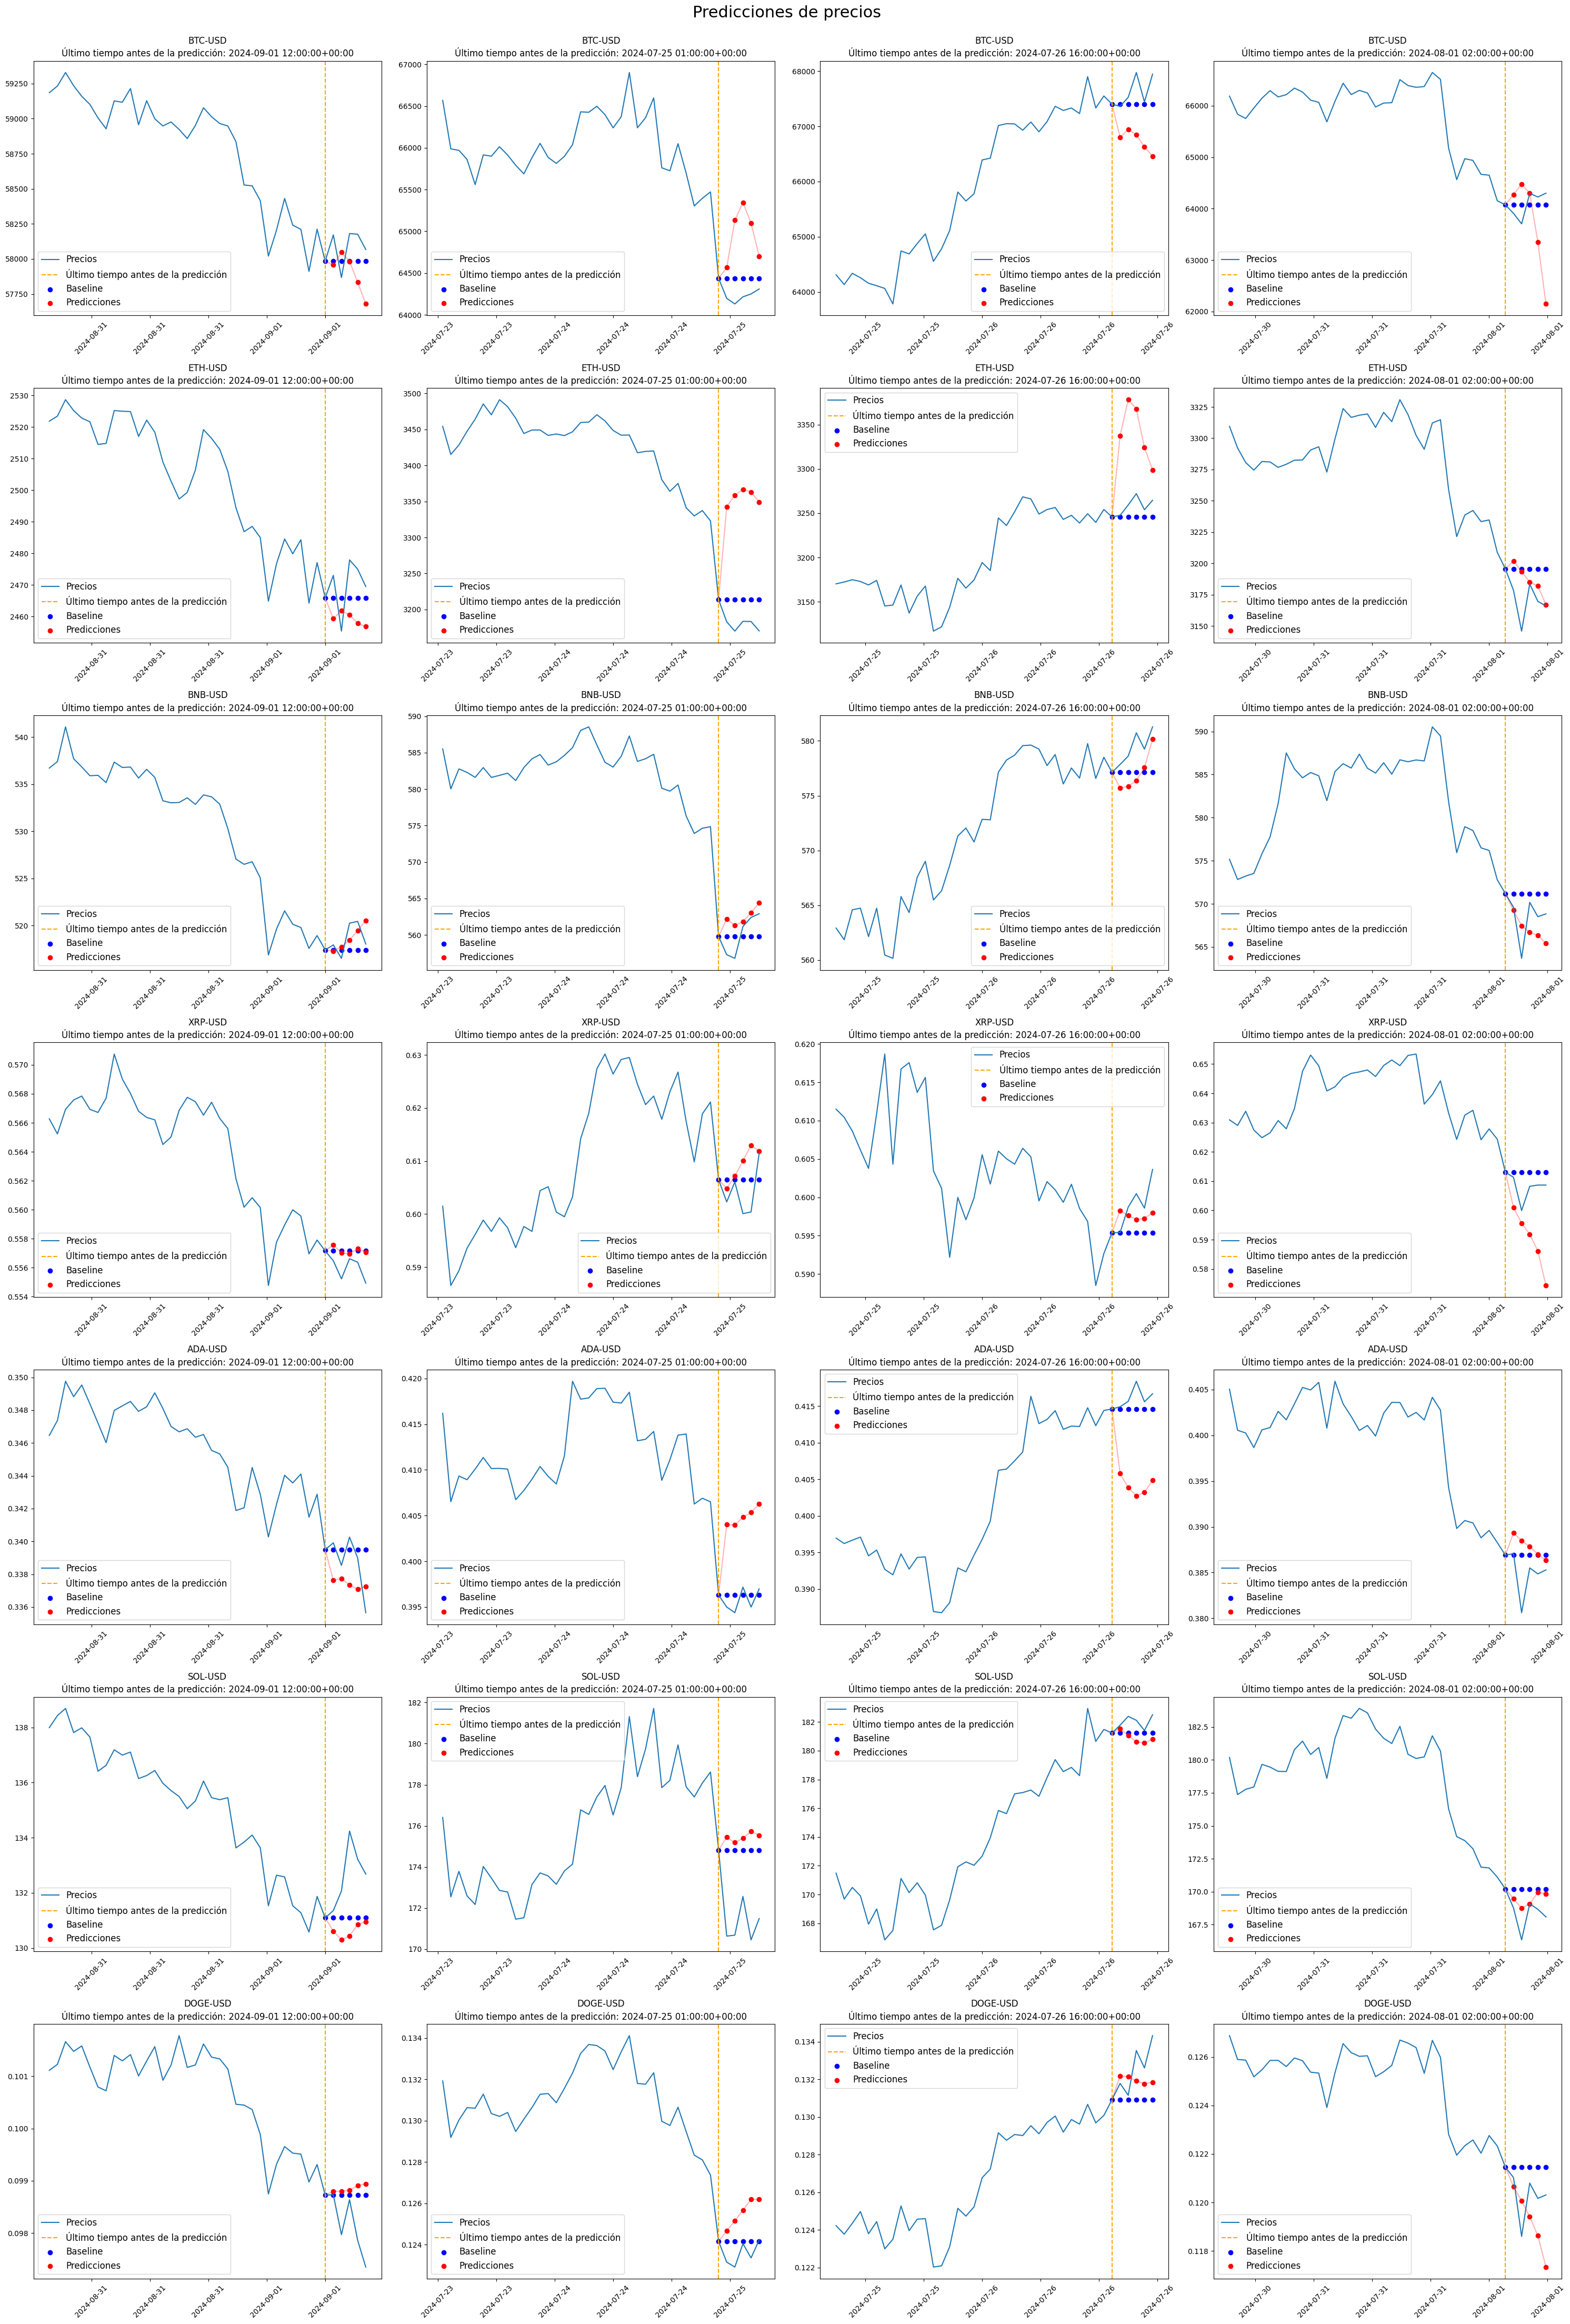

In [33]:
pred_norm, pred_norm_raw, mae_norm, mae_norm_raw = predictions_analysis(
    model=model_norm,
    X_test=X_test_norm,
    y_test=y_test_norm,
    y_test_raw=y_test_raw,
    back2rawdata=lambda data: norm_test.inverse_transform(data),
)

#### Predicción con banqueo (Min-Max scaling) local

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.16117343973611206
ETH-USD : 0.24201988270973038
BNB-USD : 0.17487134264399992
XRP-USD : 0.26244017382597534
ADA-USD : 0.2566362439773021
SOL-USD : 0.17290351385810496
DOGE-USD : 0.16523247190179832

Errores absolutos medios en la escala de los precios:
BTC-USD : 736.1685432579499
ETH-USD : 64.60759916575834
BNB-USD : 7.464989986118401
XRP-USD : 0.016568659326064206
ADA-USD : 0.009322960179291689
SOL-USD : 2.9821894993337783
DOGE-USD : 0.001930688589845462


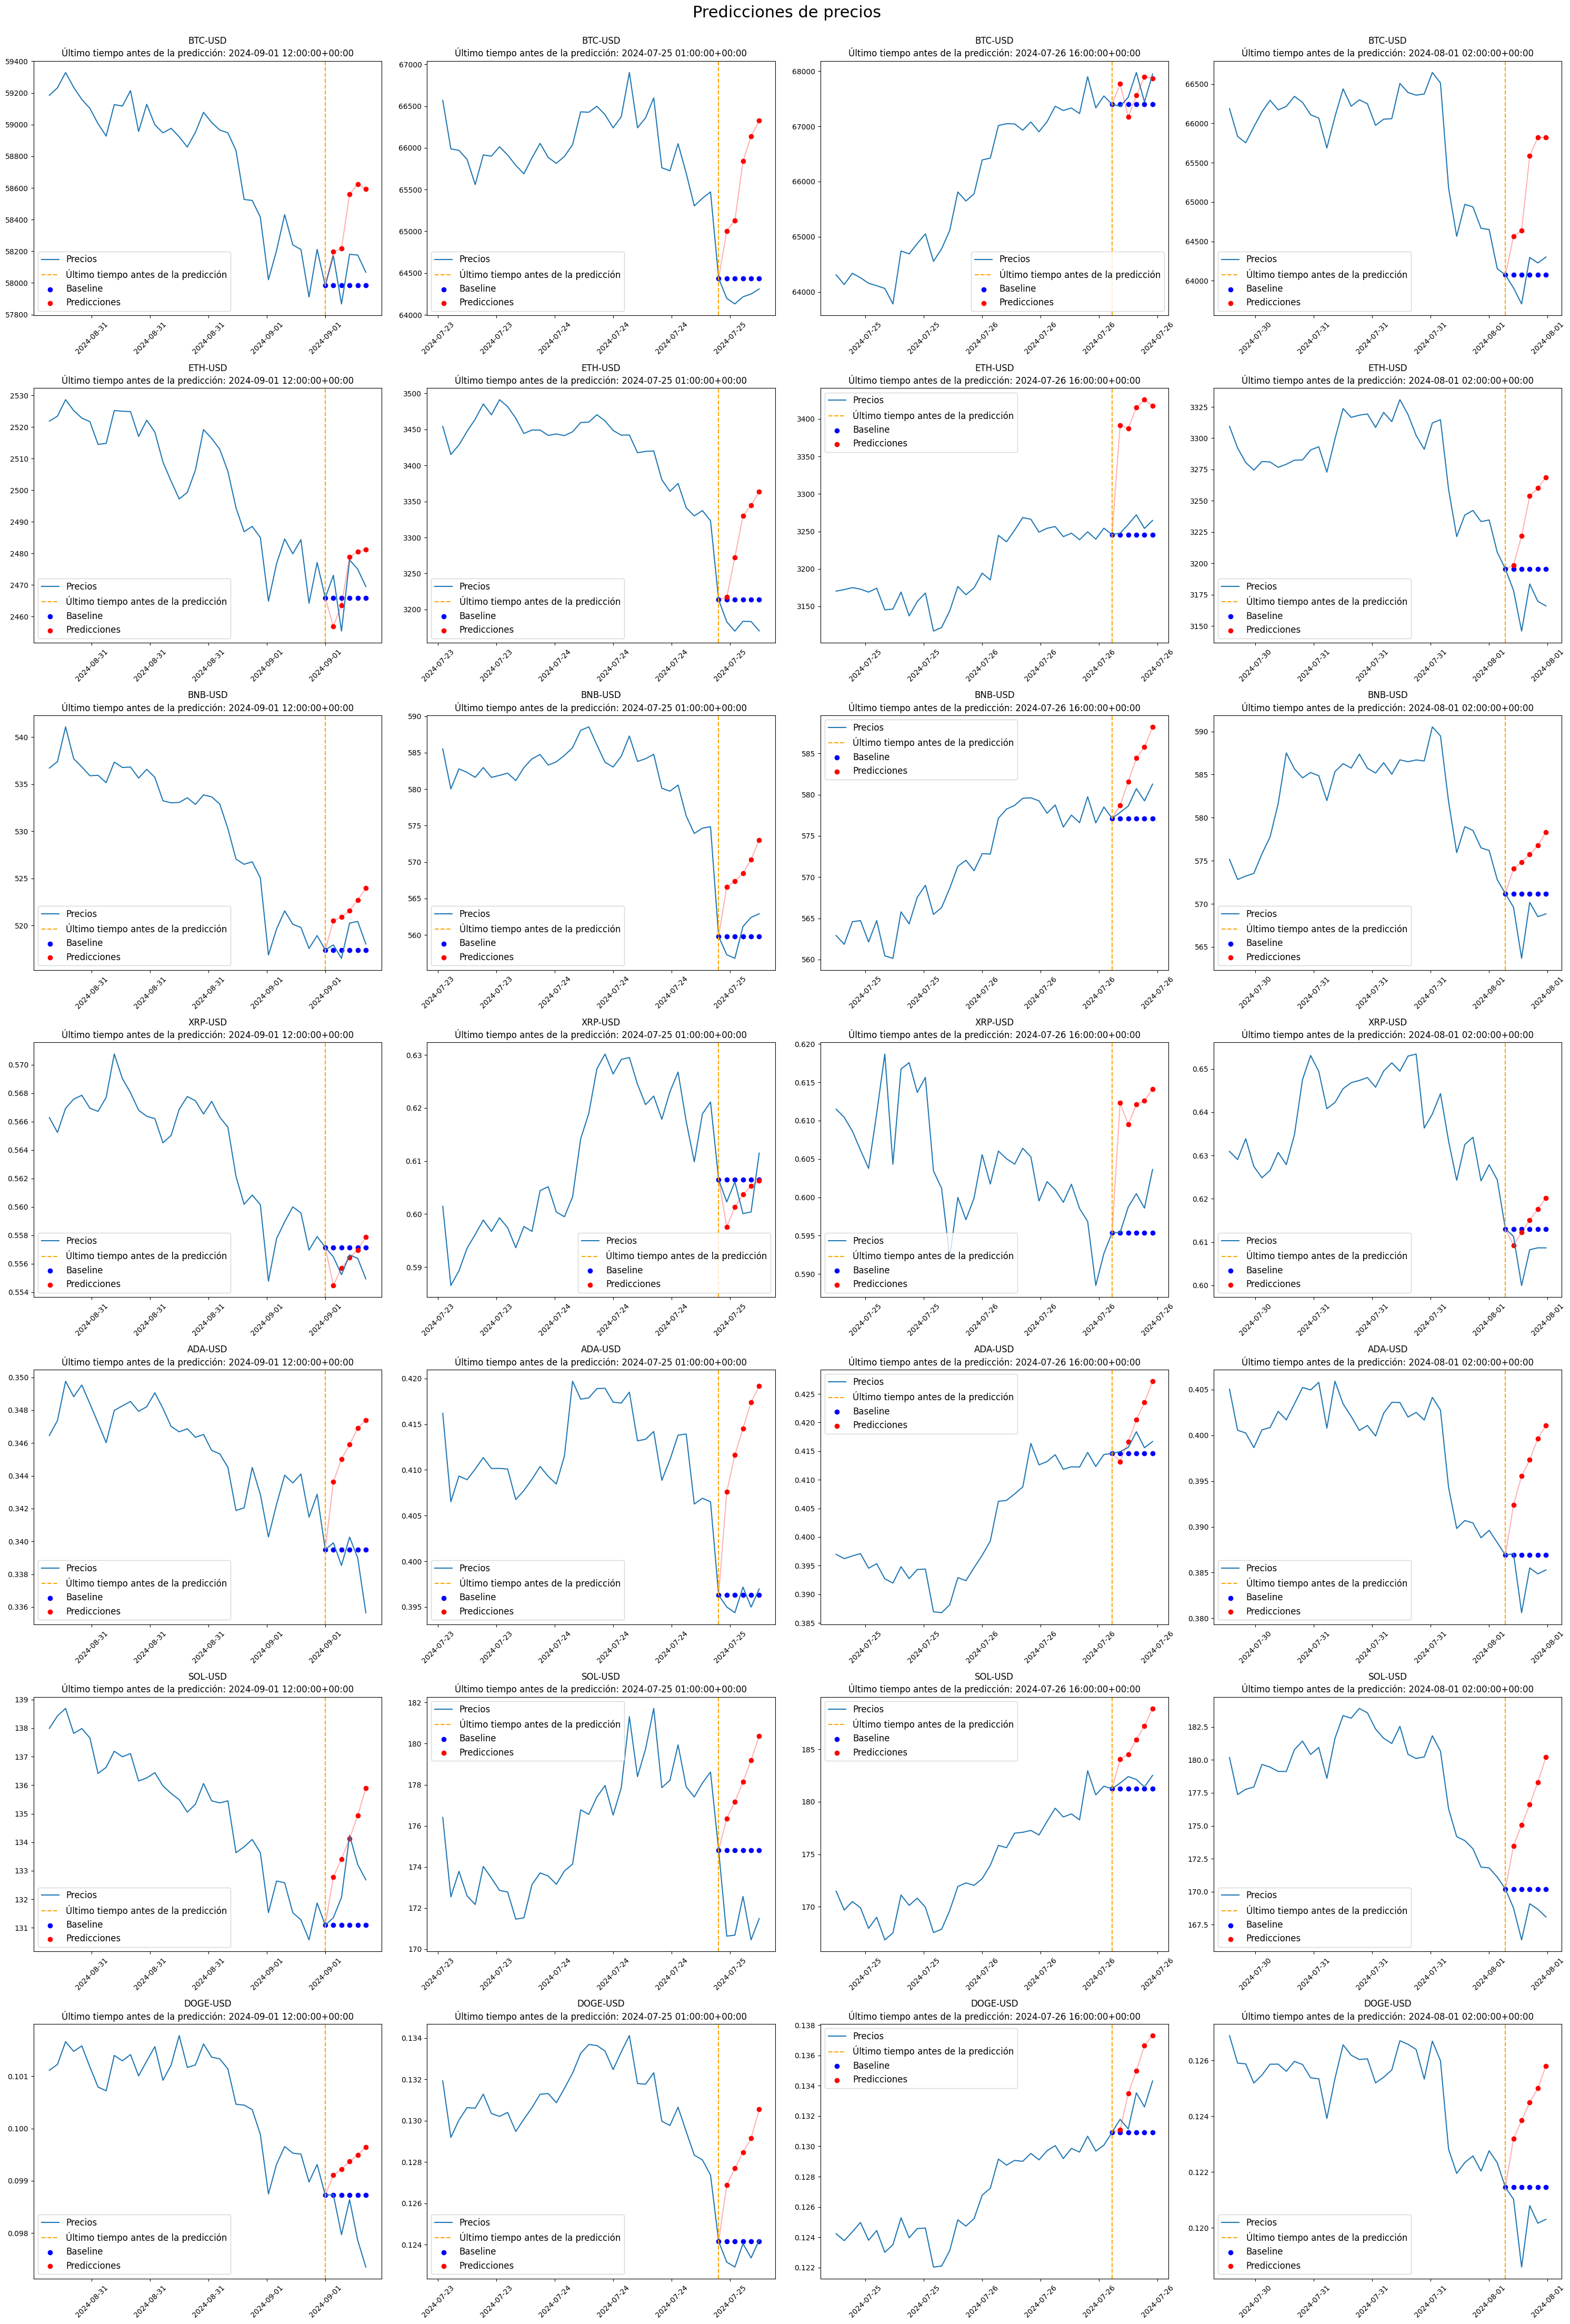

In [34]:
pred_minmax, pred_minmax_raw, mae_minmax, mae_minmax_raw = predictions_analysis(
    model=model_minmax,
    X_test=X_test_minmax,
    y_test=y_test_minmax,
    y_test_raw=y_test_raw,
    back2rawdata=lambda data: minmax_scaler_test.inverse_transform(data),
)

#### Predicción en escala logarítmica

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step

Errores absolutos medios en la escala normalizada:
BTC-USD : 0.08211028144209843
ETH-USD : 0.07018865350744864
BNB-USD : 0.3078593624160089
XRP-USD : 0.051596182416347426
ADA-USD : 0.26150920467551464
SOL-USD : 0.30228413642471624
DOGE-USD : 0.07523667325216186

Errores absolutos medios en la escala de los precios:
BTC-USD : 4745.982506695615
ETH-USD : 191.98775955231065
BNB-USD : 140.23145540824896
XRP-USD : 0.02891117682538709
ADA-USD : 0.10939918615302445
SOL-USD : 38.1738322218992
DOGE-USD : 0.008870271810896939


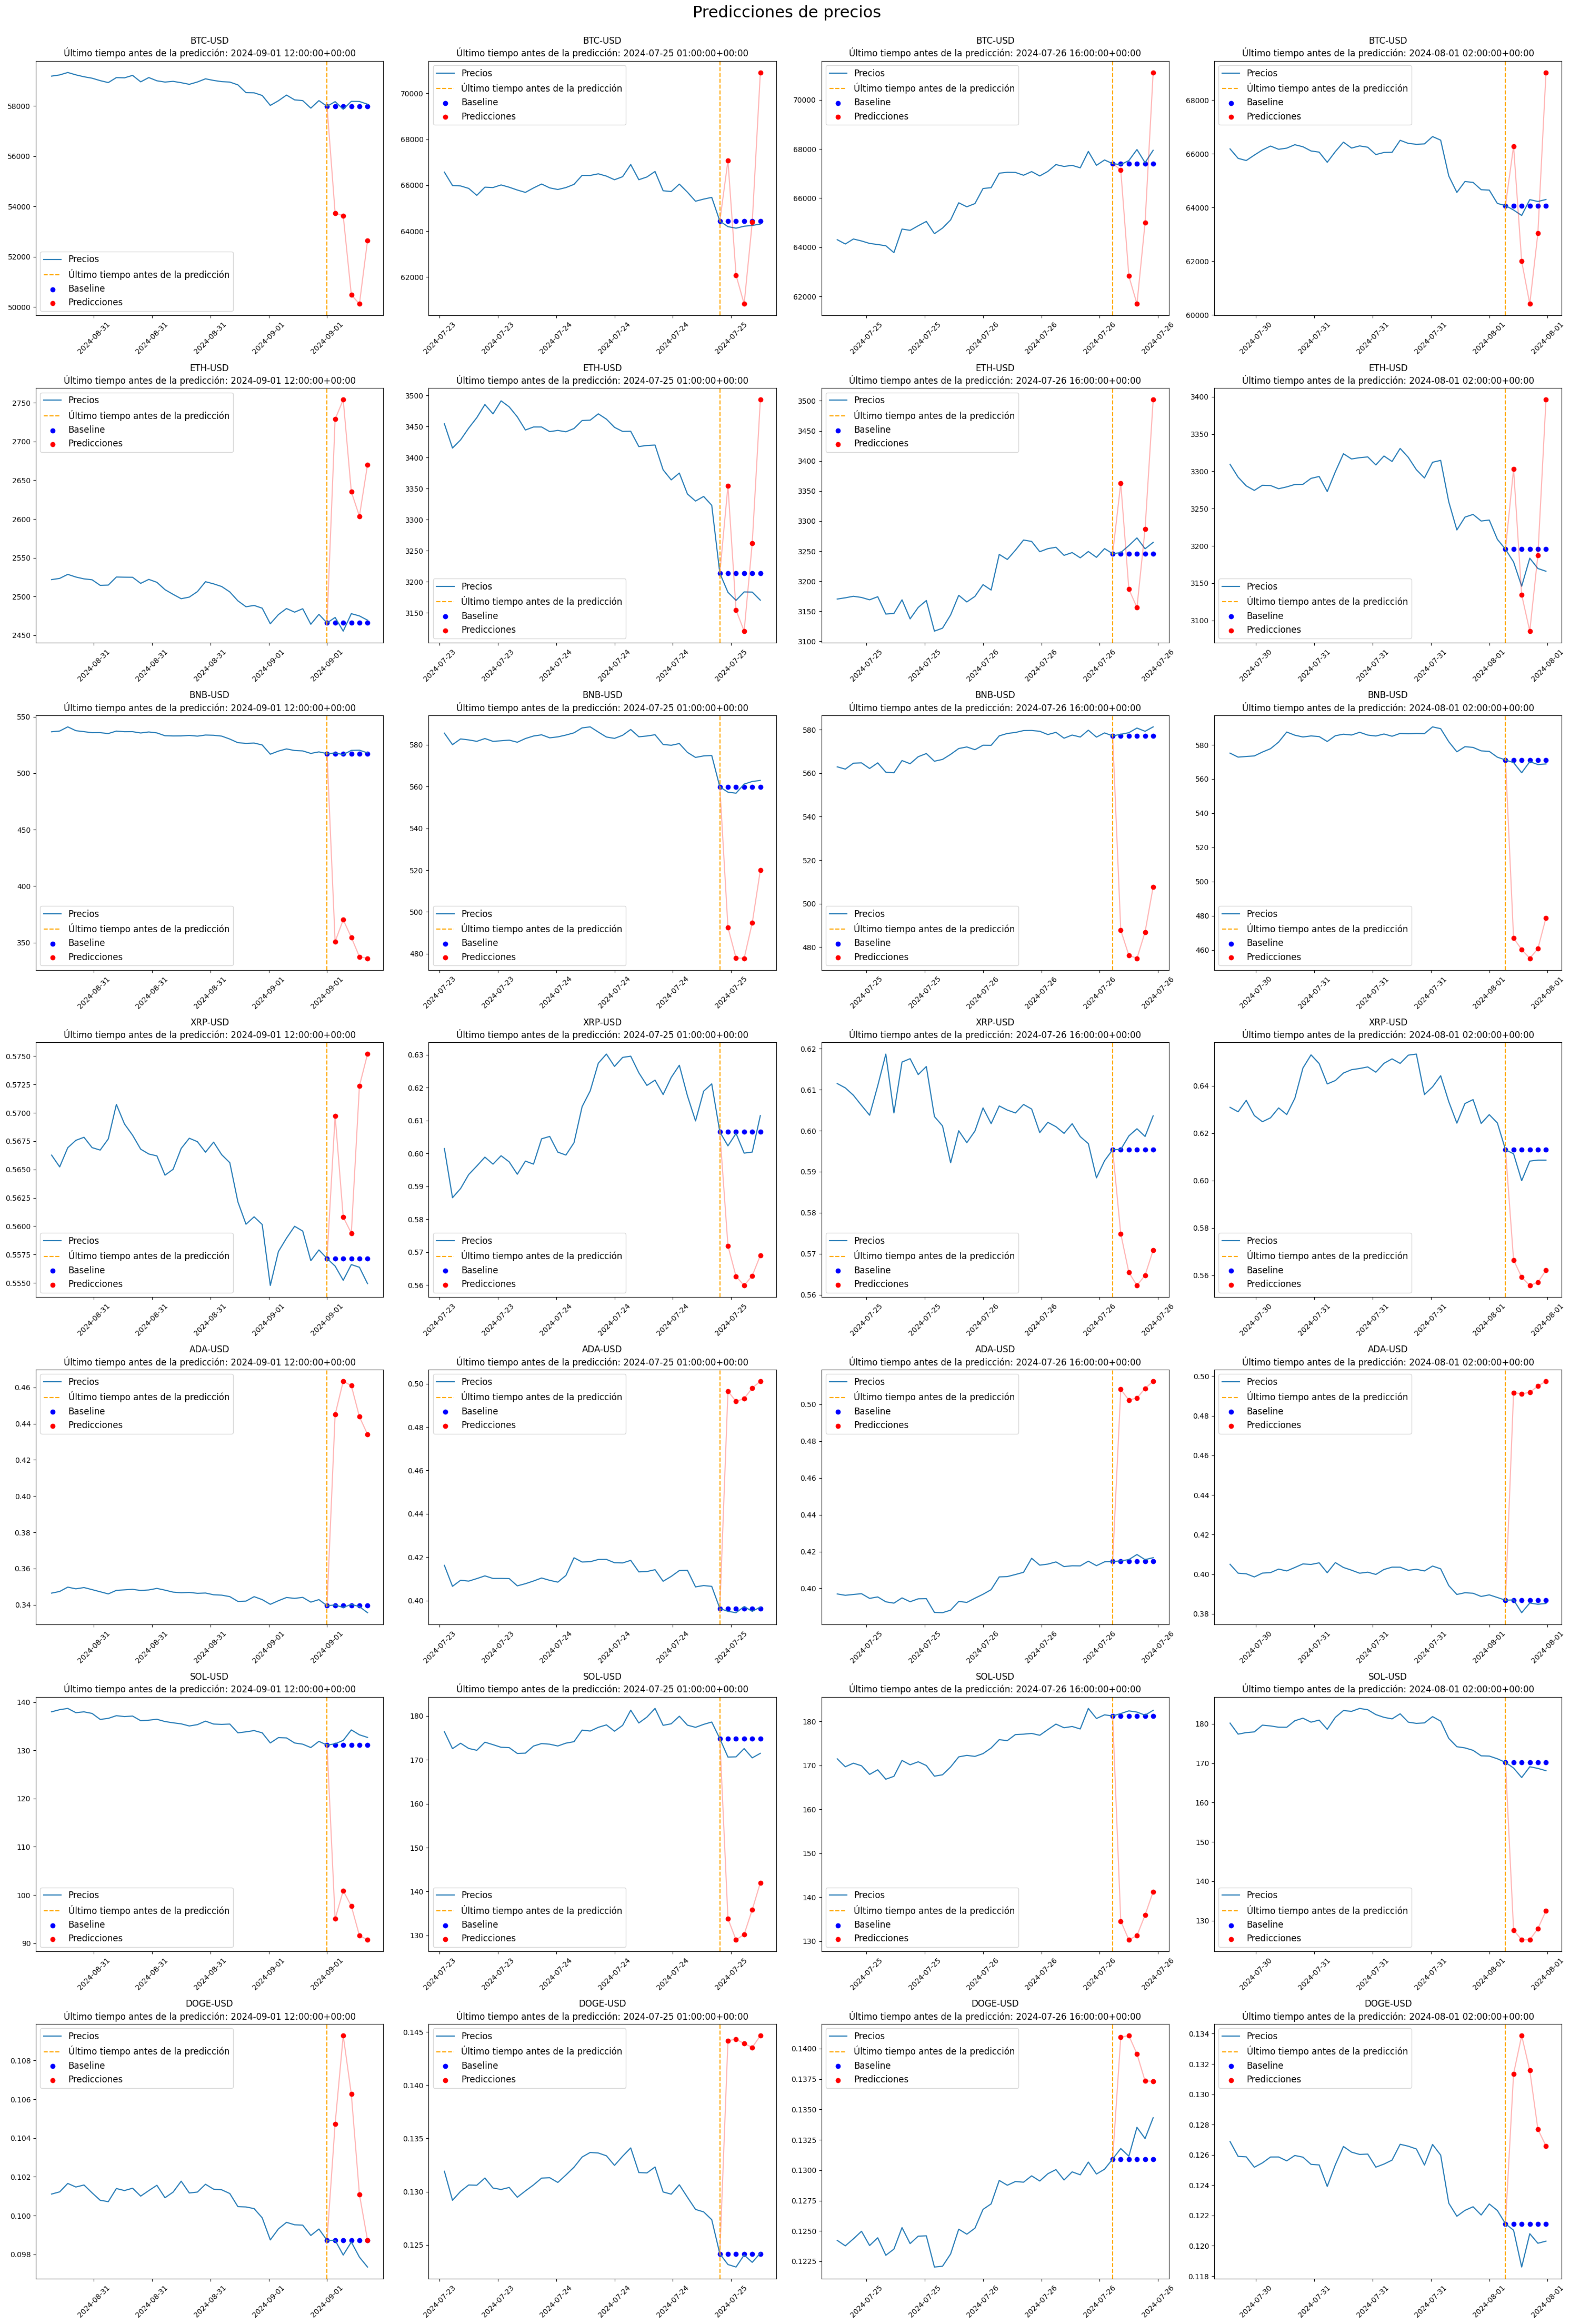

In [35]:
pred_log, pred_log_raw, mae_log, mae_log_raw = predictions_analysis(
    model=model_log,
    X_test=X_test_log,
    y_test=y_test_log,
    y_test_raw=y_test_raw,
    back2rawdata=lambda data: np.exp(data),
)

In [40]:
def plot_log_predictions(log_predictions: np.ndarray, random_seed: int = 0, window_size: int = 40):
    # function to plot log_predictions in four random times and for each crypto. 
    # columns in plot correspond to the selected times, and rows correspond to cryptos.
    
    np.random.seed(random_seed)
    rand_ind = np.random.choice(n_test-T, size=4, replace=False)
    
    n_rows, n_cols = 7, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 45))

    fig.suptitle("Predicciones escala logarítmica", fontsize=22)

    # Iterate over each subplot (i, j) to plot prices of i-th crypto and visually evaluate performance of prediction j
    for j in range(n_cols):
        jth_time = index2timestamp(rand_ind[j], "test") # time t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1})
        jth_data = np.log(dataset_df.loc[
            jth_time + pd.Timedelta(hours=T-window_size) : jth_time + pd.Timedelta(hours=T-1)
        ]) # from the window of size T starting at t, just consider the last window_size points
        
        pred_times = jth_data.index[-m:] # predicted times
        last_time = jth_data.index[-m-1] # last time t+\tau -1
        
        for i in range(n_rows):
            ith_crypto = cryptos[i]
            last_log_price = np.log(dataset_df.loc[last_time][ith_crypto])
            
            axes[i, j].plot(jth_data[ith_crypto], label="Log-Precios")
            axes[i, j].plot([last_time]+[t for t in pred_times], [last_log_price]+[pt for pt in log_predictions[rand_ind[j], :, i]], color="r", alpha=0.3)
            axes[i, j].axvline(last_time, color='orange', linestyle='--', label='Último tiempo antes de la predicción')
            axes[i, j].scatter([last_time] + [t for t in pred_times], [last_log_price]*(m+1), color="b", label="Baseline")
            axes[i, j].scatter(pred_times, log_predictions[rand_ind[j], :, i], color="r", label="Predicciones")
            axes[i, j].set_title(f"{ith_crypto}\nÚltimo tiempo antes de la predicción: {last_time}", fontsize=12)
            axes[i, j].xaxis.set_major_locator(plt.MaxNLocator(7))
            axes[i, j].tick_params(axis="x", labelrotation=45)
            axes[i,j ].legend(fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

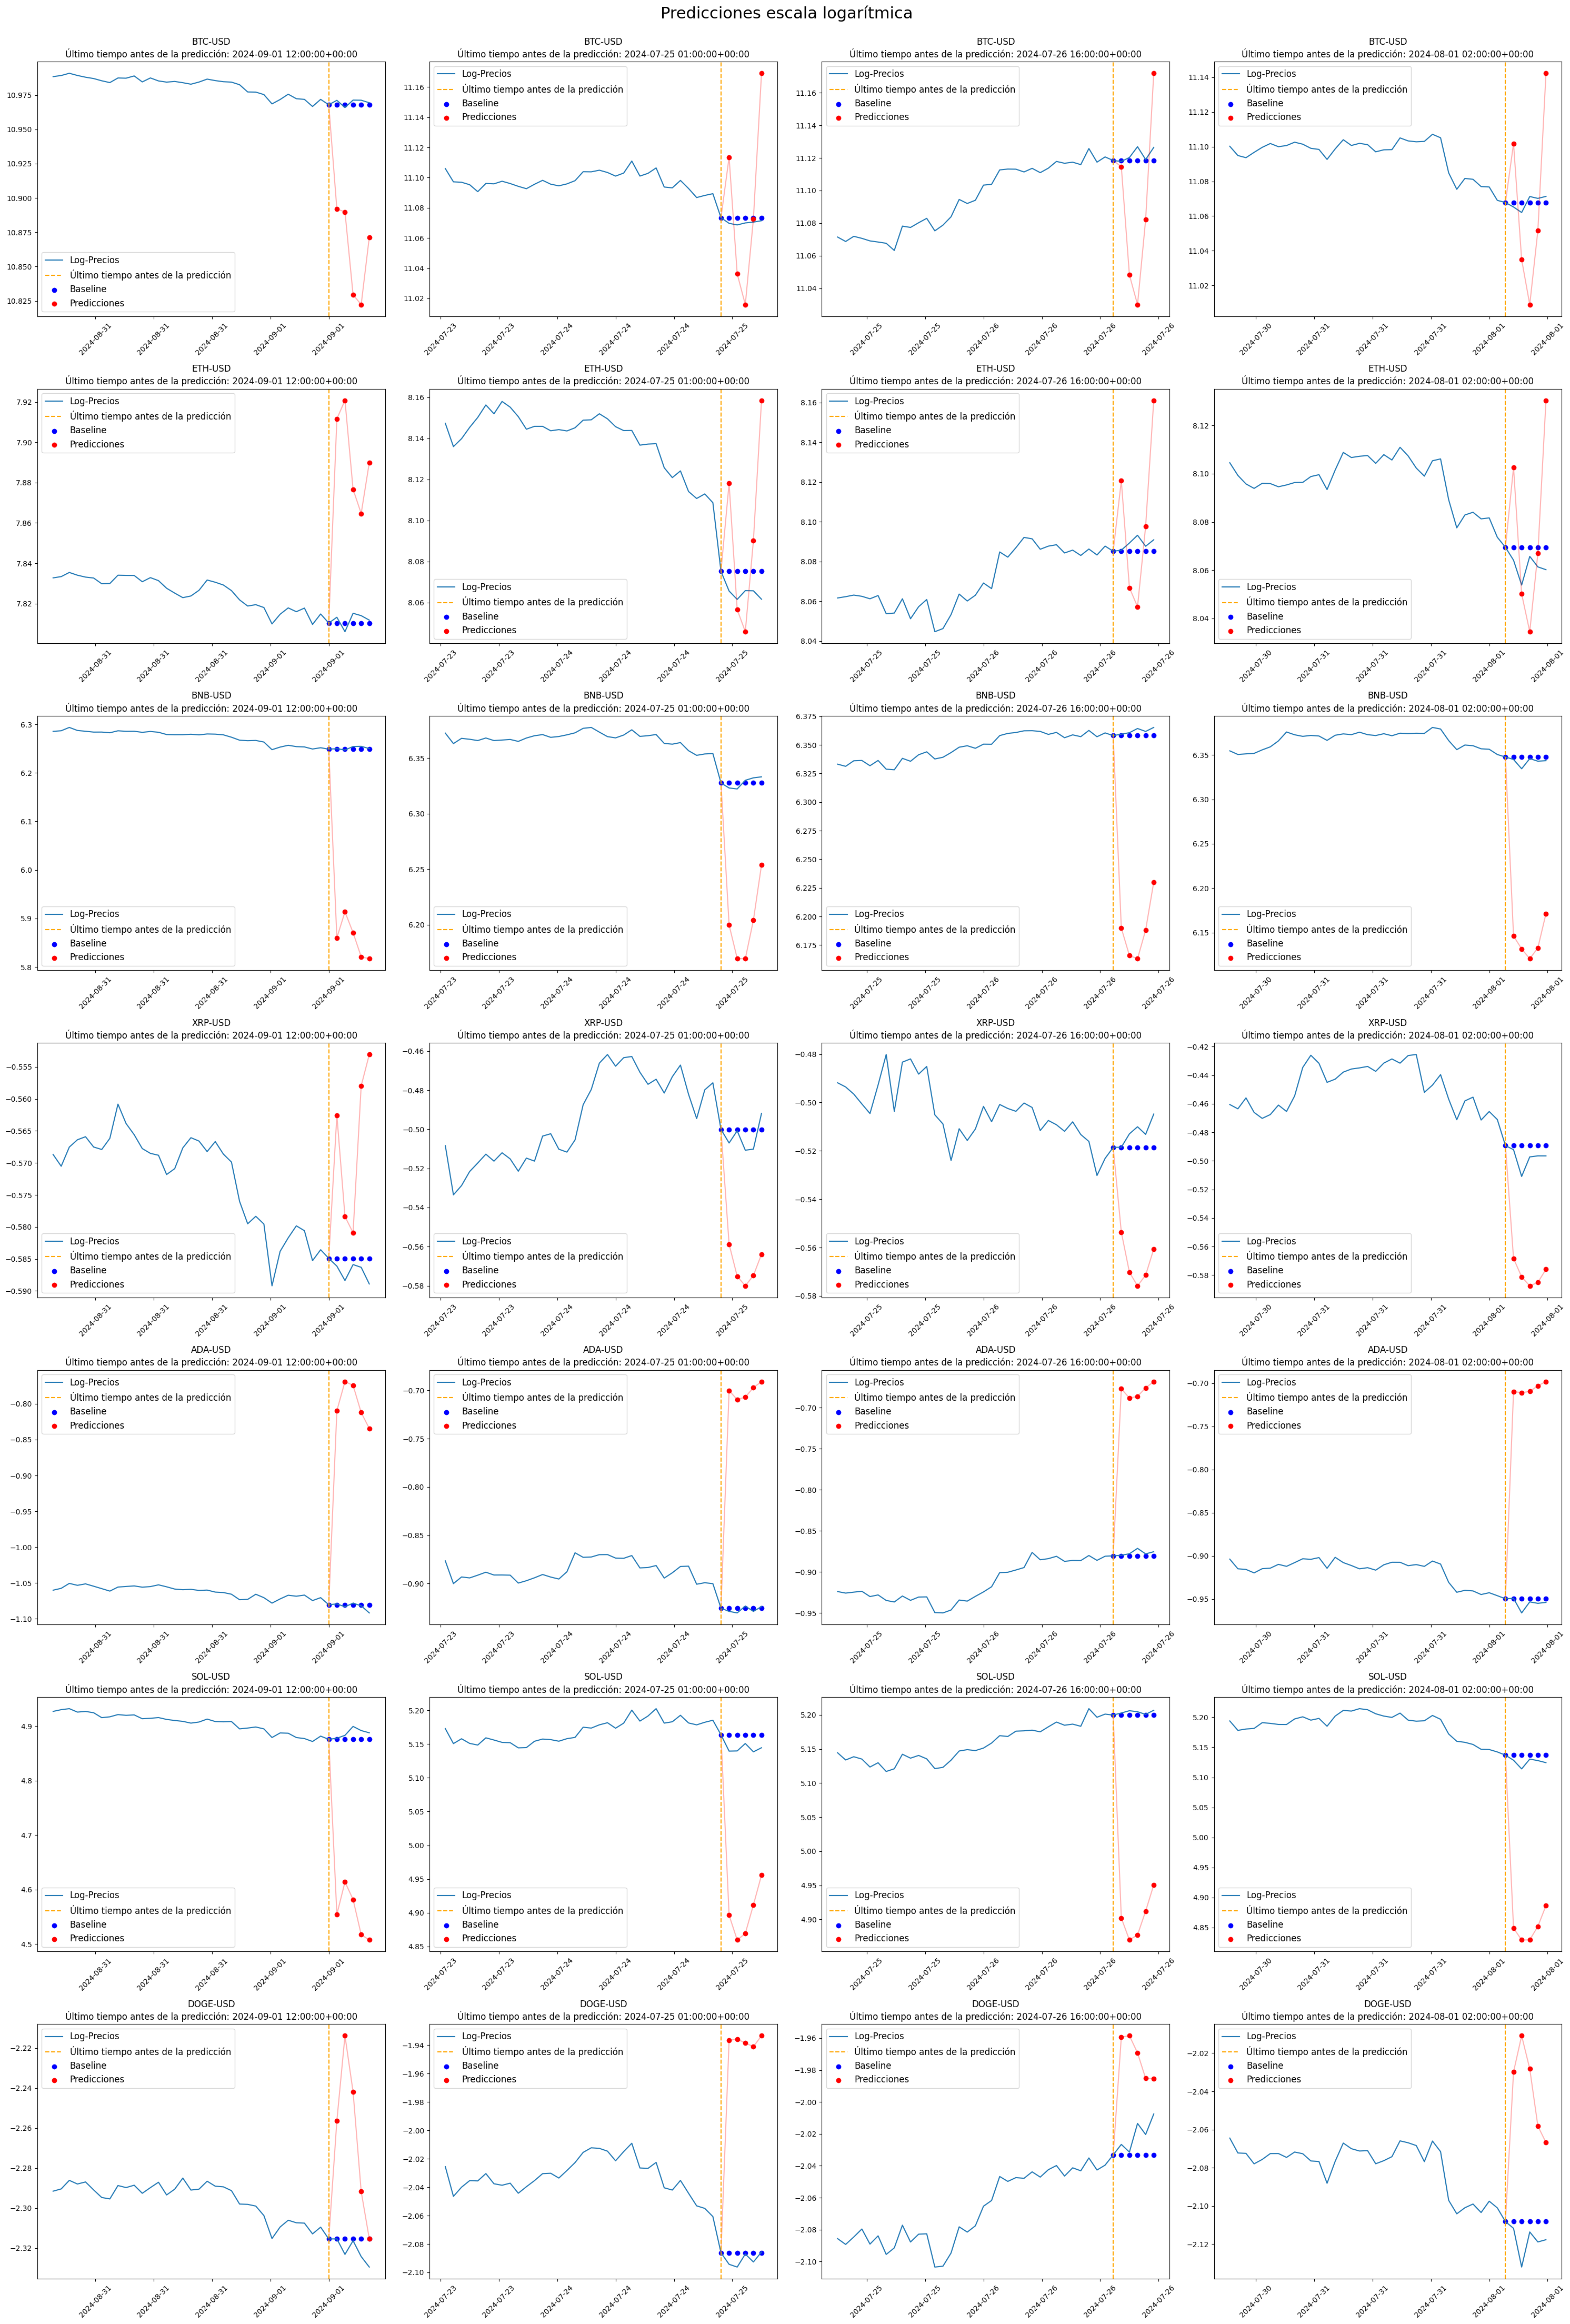

In [41]:
plot_log_predictions(pred_log)

## Resultados y conclusiones

El error absoluto medio cometido por el baseline en la escala de los precios se muestra a continuación.

In [36]:
baseline = np.zeros(shape=y_test_raw.shape)
for i in range(y_test_raw.shape[0]):
    baseline[i] = np.array([X_test_raw[i, -1, :] for _ in range(m)])
    
baseline_flat = baseline.reshape(-1, d_model)
y_test_raw_flat = y_test_raw.reshape(-1, d_model)

mae_baseline = mean_absolute_error(
    y_test_raw_flat, baseline_flat, multioutput="raw_values"
)

print("Errores absolutos medios en la escala de los precios:")
for i, crypto in enumerate(cryptos):
    print(crypto, ":", mae_baseline[i])

Errores absolutos medios en la escala de los precios:
BTC-USD : 408.4316001017792
ETH-USD : 21.930871508406213
BNB-USD : 3.790757282105228
XRP-USD : 0.005203885958048058
ADA-USD : 0.0033295072857807283
SOL-USD : 1.5674813890629713
DOGE-USD : 0.0010761421726537992


Para ver el performance de todos los modelos en conjunto, vamos a ver el histograma de errores absolutos medios (*MAE, Mean Absolute Error*) obtenidos en el conjunto de prueba por criptomoneda y por modelo.

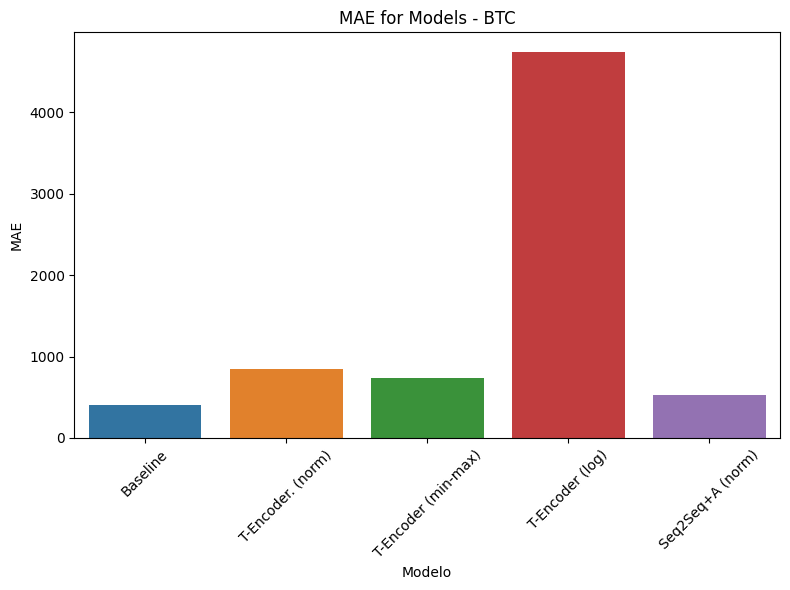

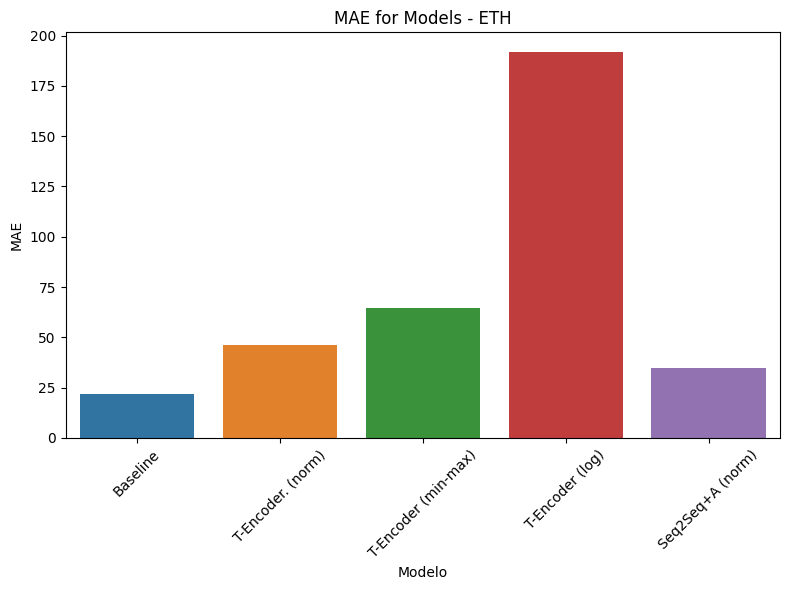

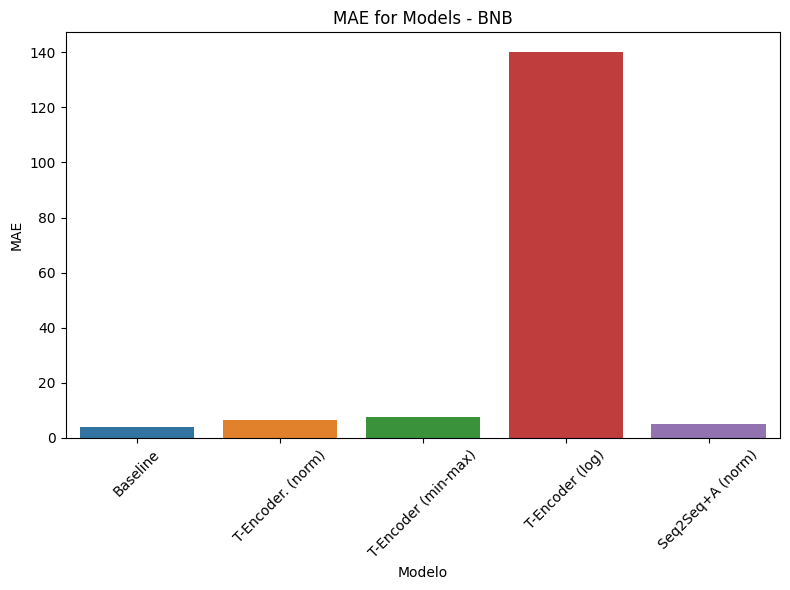

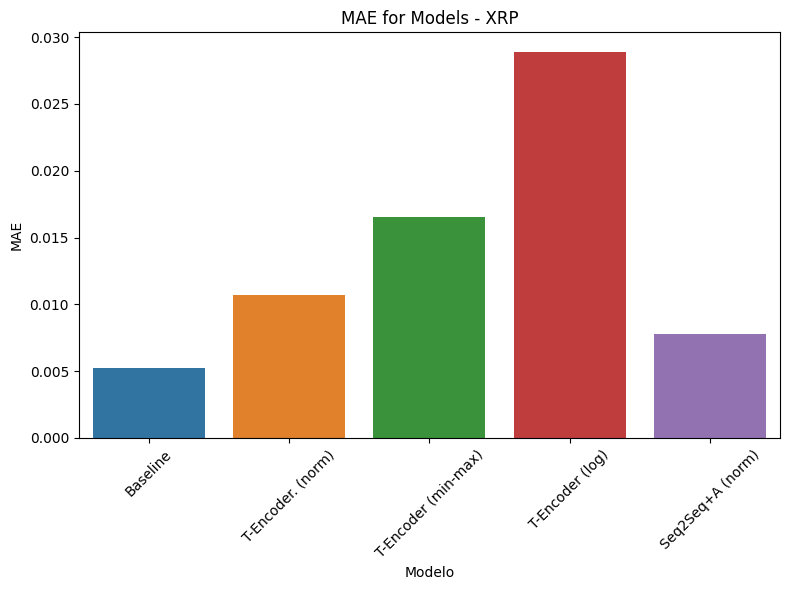

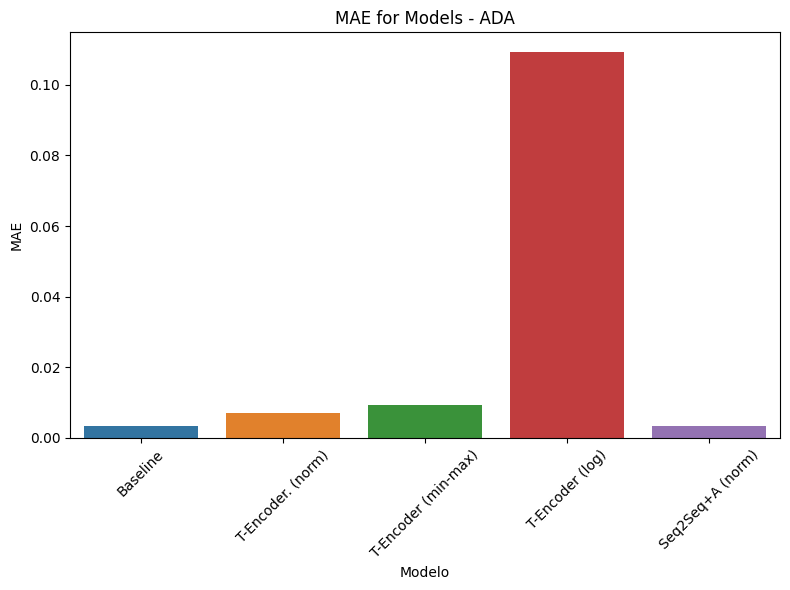

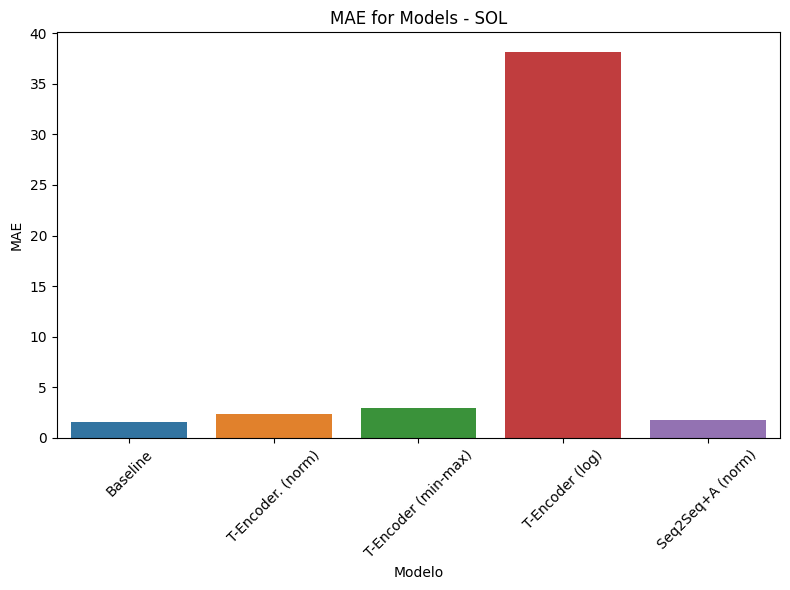

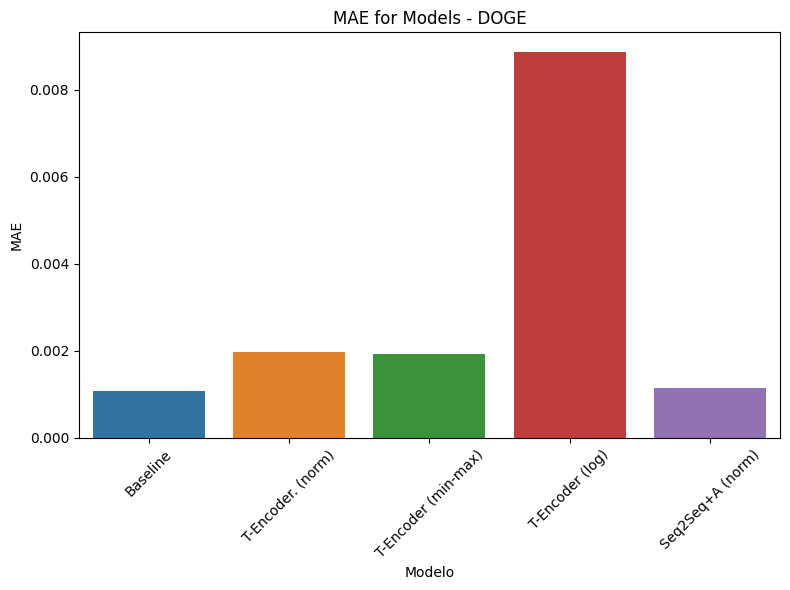

In [58]:
modelos = [
    "Baseline",
    "T-Encoder. (norm)",
    "T-Encoder (min-max)",
    "T-Encoder (log)",
    "Seq2Seq+A (norm)",
]
errores = [mae_baseline, mae_norm_raw, mae_minmax_raw, mae_log_raw, mae_seq2seq_raw]
cripto_names = ["BTC", "ETH", "BNB", "XRP", "ADA", "SOL", "DOGE"]

errors_dict = {"Modelo": [], "MAE": [], "Criptomoneda": []}

for i in range(len(modelos)):
    errors_dict["Modelo"] = errors_dict["Modelo"] + [modelos[i]] * 7
    errors_dict["MAE"] = errors_dict["MAE"] + errores[i].tolist()
    errors_dict["Criptomoneda"] = errors_dict["Criptomoneda"] + cripto_names

errors_df = pd.DataFrame(errors_dict)

for crypto in cripto_names:
    plt.figure(figsize=(8, 6))
    crypto_df = errors_df[errors_df["Criptomoneda"] == crypto]
    sns.barplot(data=crypto_df, x="Modelo", y="MAE", hue="Modelo", dodge=False)
    plt.title(f"MAE for Models - {crypto}")
    plt.ylabel("MAE")
    plt.xlabel("Modelo")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

También mostramos una tabla con los errores MAE.

In [37]:
pd.DataFrame.from_dict(
    {
        "Baseline": mae_baseline,
        "Transformer Encoder (normalización)": mae_norm_raw,
        "Transformer Encoder (banqueo)": mae_minmax_raw,
        "Transformer Encoder (logaritmo)": mae_log_raw,
        "Seq2Seq+Atención (normalización)": mae_seq2seq_raw,
    },
    orient="index",
    columns=["BTC", "ETH", "BNB", "XRP", "ADA", "SOL", "DOGE"],
)

BTC         ETH         BNB  \
Baseline                              408.431600   21.930872    3.790757   
Transformer Encoder (normalización)   852.746865   46.394271    6.547556   
Transformer Encoder (banqueo)         736.168543   64.607599    7.464990   
Transformer Encoder (logaritmo)      4745.982507  191.987760  140.231455   
Seq2Seq+Atención (normalización)      528.211598   34.604397    4.894761   

                                          XRP       ADA        SOL      DOGE  
Baseline                             0.005204  0.003330   1.567481  0.001076  
Transformer Encoder (normalización)  0.010694  0.006997   2.386979  0.001977  
Transformer Encoder (banqueo)        0.016569  0.009323   2.982189  0.001931  
Transformer Encoder (logaritmo)      0.028911  0.109399  38.173832  0.008870  
Seq2Seq+Atención (normalización)     0.007804  0.003482   1.786729  0.001147

Podemos concluir que el preprocesamiento logarítmico no fue bueno, mientras que la normalización y banqueo local tienen comportamientos similares. Sin embargo, el Seq2Seq con atención fue mejor que los modelos basados en el encoder del Transformer, y ningún modelo pudo ganarle al baseline.